In [27]:
#%% Mount Google drive if you use colab for save and load files
if 'google.colab' in str(get_ipython()):
  colab = 1
  print('Running on Colab')
  from google.colab import drive
  drive.mount('/content/drive')

  # Set your path on the google drive here for save and download files
  path = '/content/drive/MyDrive/Transformer_MPC/02_Surrogate/FOPDT/SISO/'
    
else:
  colab = 0
  print('Not running on Colab')
  path = ''

# Install(if it hasn't been) and Import GEKKO package
try:
    from gekko import GEKKO
except:
    !pip install gekko
    # restart kernel if this doesn't import
    from gekko import GEKKO

Not running on Colab


In [28]:
# from gekko import GEKKO
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from pickle import dump, load
from sklearn.preprocessing import MinMaxScaler
import time

# For LSTM model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Reshape, Conv1DTranspose, Conv2DTranspose

from keras.callbacks import EarlyStopping
from keras.models import load_model
from tqdm.keras import TqdmCallback

In [29]:
# load and combine data

tcLab1 = pd.read_pickle('TCLab_MIMO_Data_023_20000_0_100.pkl') # Put the original name
tcLab2 = pd.read_pickle('TCLab_MIMO_Data_024_30000_0_100.pkl') # Put the original name
tcLab3 = pd.read_pickle('TCLab_MIMO_Data_025_30000_0_100.pkl') # Put the original name
tcLab4 = pd.read_pickle('TCLab_MIMO_Data_026_30000_0_100.pkl') # Put the original name
tcLab5 = pd.read_pickle('TCLab_MIMO_Data_027_15000_0_100.pkl') # Put the original name

tcLab = pd.concat([tcLab1, tcLab2, tcLab3, tcLab4, tcLab5], ignore_index=True)

tcLab

H1        H2      T1      T2
0        0.000000   0.00000  28.633  27.988
1        0.000000   0.00000  28.633  27.988
2        0.000000   0.00000  28.633  27.988
3        0.000000   0.00000  28.633  27.988
4        0.000000   0.00000  28.633  27.988
...           ...       ...     ...     ...
124995  71.089156  24.05536  72.783  50.869
124996  71.089156  24.05536  72.944  50.869
124997  71.089156  24.05536  72.783  51.353
124998  71.089156  24.05536  72.783  50.869
124999  71.089156  24.05536  72.783  51.997

[125000 rows x 4 columns]

In [30]:
# Down sampling

sec = 125000
interval = 5

# tcLab = pd.read_pickle('TCLab_MIMO_Data_026_30000_0_100.pkl') # Put the original name

downsampled_interval = interval # New interval (sec)

tcLab_resample = tcLab.iloc[::downsampled_interval, :]

In [31]:
data = tcLab_resample
print(data.shape)

(25000, 4)


## Select Training data Range

In [32]:
# data = data[0:100]

In [33]:
# file = open(file='/content/drive/MyDrive/LSTM_MPC/FOPDT/closed_loop_data_1200.pkl',mode='wb')
# dump([u1_store, u2_store, y1_store, y2_store, SP1, SP2], file)
# file.close()

fig = make_subplots(rows=1, cols=1, shared_xaxes=True)
fig.add_trace(go.Scatter(y=data["T1"],name="T1"), row=1, col=1)
fig.add_trace(go.Scatter(y=data["T2"],name="T2"), row=1, col=1)
fig.add_trace(go.Scatter(y=data["H1"],name="H1"), row=1, col=1)
fig.add_trace(go.Scatter(y=data["H2"],name="H2"), row=1, col=1)
# fig.add_trace(go.Scatter(y=u1_store,name="u1"), row=2, col=1)
# fig.add_trace(go.Scatter(y=u2_store,name="u2"), row=2, col=1)

# fig.update_layout(
#     template="plotly_white",
#     font_family="Times New Roman",
#     font_size = 20
#     )

# fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True, row=1 , col=1)
# fig.update_xaxes(title_text='Time',showline=True, linewidth=2, linecolor='black', mirror=True, row=2, col=1)
# fig.update_yaxes(title_text='y', showline=True, linewidth=2, linecolor='black', mirror=True, row=1, col=1)
# fig.update_yaxes(title_text='u', showline=True, linewidth=2, linecolor='black', mirror=True, row=2, col=1)
# fig.show()

# fig.write_image("fig1.eps")

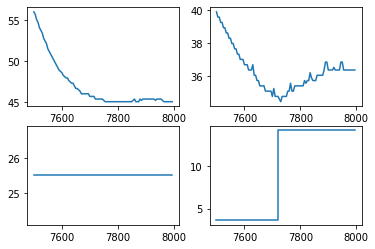

In [34]:
plt.figure(0)
plt.subplot(2,2,1)
plt.plot(data["T1"][1500:1600])
plt.subplot(2,2,2)
plt.plot(data["T2"][1500:1600])
plt.subplot(2,2,3)
plt.plot(data["H1"][1500:1600], drawstyle='steps')
plt.subplot(2,2,4)
plt.plot(data["H2"][1500:1600], drawstyle='steps')

plt.show()

## 4. Train LSTM Network

In [35]:
window = 5
P = 5

# Scale features
s1 = MinMaxScaler(feature_range=(-1,1))
# s1.data_min_=[0,0,0,0]
# s1.data_max_=[5,5,5,5]
Xs = s1.fit_transform(data[['H1', 'H2', 'T1', 'T2']])
s2 = MinMaxScaler(feature_range=(-1,1))
# s2.data_min_=[0,0,0,0]
# s2.data_max_=[10,10,10,10]
Ys = s2.fit_transform(data[['T1', 'T2']])

In [36]:
Ys.shape, Xs.shape

((25000, 2), (25000, 4))

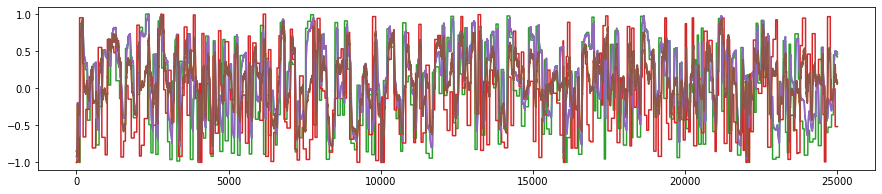

In [37]:
plt.figure(figsize=[15,3])
plt.plot(Ys)
plt.plot(Xs)

In [38]:
# Save model parameters
model_params = dict()
model_params['Xscale'] = s1
model_params['yscale'] = s2
model_params['window'] = window
model_params['P'] = P # prediction horizon

dump(model_params, open(path + 'model_param_MIMO_P5.pkl', 'wb'))


In [39]:
nstep = Xs.shape[0]
val_ratio = 0.5
cut_index = int(nstep*val_ratio) # index number to separate the training and validation set
print(cut_index)
Xs_train = Xs[0:cut_index]
Ys_train = Ys[0:cut_index]
Xs_val = Xs[cut_index:]
Ys_val = Ys[cut_index:]

12500


## Preparing training data for simultaneous **multi-step** prediction
X_train $\in$ $\mathbb{R}$ $^{\text{Batch}\: \times \:(\text{window + P})\: \times\: \text{Nvariables}}$  
Y_train $\in$ $\mathbb{R}$ $^{\text{Batch}\: \times \:\text{P}\: \times\: \text{Nvariables}}$  


In [40]:
X_train = []
Y_train = []
for i in range(window,len(Xs_train)-P):
    X_train.append(Xs_train[i-window:i+P,:])
    Y_train.append(Ys_train[i:i+P])

X_val = []
Y_val = []
for i in range(window,len(Xs_val)-P):
    X_val.append(Xs_val[i-window:i+P,:])
    Y_val.append(Ys_val[i:i+P])

In [41]:
# Reshape data to format accepted by LSTM
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_val, Y_val = np.array(X_val), np.array(Y_val)

## Replacing outputs in the prediction horizon ($\text y_{k+i}$) with the latest measured value ($\text y_k$)  , where, $i = 1, 2, ... ,\text P$

In [42]:
for i in range(0, len(X_train)):
  X_train[i][window:,2] = X_train[i][window-1,2]
  X_train[i][window:,3] = X_train[i][window-1,3]

for i in range(0, len(X_val)):
  X_val[i][window:,2] = X_val[i][window-1,2]
  X_val[i][window:,3] = X_val[i][window-1,3]

In [43]:
# Demension of training data set
# Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1]*Y_train.shape[2]))
# Y_val = np.reshape(Y_val, (Y_val.shape[0], Y_val.shape[1]*Y_val.shape[2]))
np.shape(X_train), np.shape(Y_train)

((12490, 10, 4), (12490, 5, 2))

In [44]:
X_train[15], Y_train[15]

(array([[-1.        , -1.        , -0.93941199, -0.89644507],
        [-1.        , -1.        , -0.94950476, -0.90291223],
        [-1.        , -1.        , -0.94950476, -0.90937939],
        [-1.        , -1.        , -0.94950476, -0.90937939],
        [-1.        , -1.        , -0.94950476, -0.90937939],
        [-1.        , -1.        , -0.94950476, -0.90937939],
        [-1.        , -1.        , -0.94950476, -0.90937939],
        [-1.        , -1.        , -0.94950476, -0.90937939],
        [-1.        , -1.        , -0.94950476, -0.90937939],
        [-0.21917898, -0.19702444, -0.94950476, -0.90937939]]),
 array([[-0.94950476, -0.90937939],
        [-0.94950476, -0.92231372],
        [-0.94950476, -0.92231372],
        [-0.94950476, -0.92231372],
        [-0.95959754, -0.92231372]]))

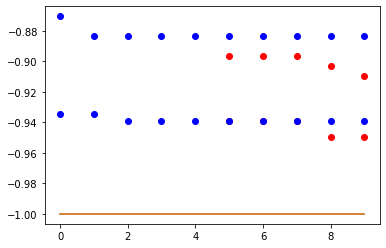

In [45]:
i = 8
t = np.linspace(0, P+window-1, P+window)
plt.plot(t[5:],Y_train[i],'ro')
plt.plot(t, X_train[i][:,2],'bo')
plt.step(t, X_train[i][:,0])
plt.plot(t, X_train[i][:,3],'bo')
plt.step(t, X_train[i][:,1])

In [46]:
Y_train[20]

array([[-0.94950476, -0.92231372],
       [-0.93941199, -0.90291223],
       [-0.91919509, -0.88997791],
       [-0.89900953, -0.88351075],
       [-0.86869985, -0.87053625]])

In [47]:
X_train[20]

array([[-1.        , -1.        , -0.94950476, -0.90937939],
       [-1.        , -1.        , -0.94950476, -0.92231372],
       [-1.        , -1.        , -0.94950476, -0.92231372],
       [-1.        , -1.        , -0.94950476, -0.92231372],
       [-0.21917898, -0.19702444, -0.95959754, -0.92231372],
       [-0.21917898, -0.19702444, -0.95959754, -0.92231372],
       [-0.21917898, -0.19702444, -0.95959754, -0.92231372],
       [-0.21917898, -0.19702444, -0.95959754, -0.92231372],
       [-0.21917898, -0.19702444, -0.95959754, -0.92231372],
       [-0.21917898, -0.19702444, -0.95959754, -0.92231372]])

In [48]:
# # Initialize LSTM model


model_lstm = Sequential()

model_lstm.add(LSTM(units=100, return_sequences=True, \
          input_shape=(X_train.shape[1],X_train.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=100, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=100))
model_lstm.add(Dropout(0.2))
model_lstm.add(tf.keras.layers.Flatten())
model_lstm.add(Dense(units=Y_train.shape[1]*Y_train.shape[2], activation='linear'))
model_lstm.add(Reshape((Y_train.shape[1], Y_train.shape[2])))
model_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error',\
              metrics = ['accuracy'])
# Allow for early exit
es_lstm = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

In [49]:
model_lstm.summary()
# Fit (and time) LSTM model
t0 = time.time()
result_lstm = model_lstm.fit(X_train, Y_train, epochs = 300, batch_size = 32,\
                             callbacks=[es_lstm, TqdmCallback(verbose=1)],\
                             verbose=0, validation_data=(X_val, Y_val))
t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))

# model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 100)           42000     
                                                                 
 dropout (Dropout)           (None, 10, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 10, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 flatten (Flatten)           (None, 100)               0

0epoch [00:00, ?epoch/s]
  0%|                                                                                       | 0/300 [00:00<?, ?epoch/s]
  0%|                                                                                    | 0.00/391 [00:00<?, ?batch/s]
  0%|▏                                                | 1.00/391 [00:05<36:08, 5.56s/batch, loss=0.234, accuracy=0.544]
  2%|▊                                                | 6.00/391 [00:05<04:30, 1.42batch/s, loss=0.142, accuracy=0.673]
  3%|█▎                                              | 11.0/391 [00:05<02:02, 3.09batch/s, loss=0.0971, accuracy=0.716]
  4%|█▉                                              | 16.0/391 [00:05<01:11, 5.26batch/s, loss=0.0742, accuracy=0.743]
  5%|██▌                                             | 21.0/391 [00:05<00:46, 8.04batch/s, loss=0.0614, accuracy=0.779]
  7%|███▏                                            | 26.0/391 [00:06<00:31, 11.4batch/s, loss=0.0527, accuracy=0.803]
  8%|███▉      

  0%|         | 1/300 [00:16<1:21:06, 16.28s/epoch, loss=0.00794, accuracy=0.922, val_loss=0.00126, val_accuracy=0.978]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00794, accuracy=0.922]
  2%|▋                                              | 6.00/391 [00:00<00:07, 54.0batch/s, loss=0.00318, accuracy=0.959]
  3%|█▍                                             | 12.0/391 [00:00<00:07, 49.8batch/s, loss=0.00288, accuracy=0.957]
  5%|██▏                                            | 18.0/391 [00:00<00:07, 52.1batch/s, loss=0.00287, accuracy=0.955]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 53.0batch/s, loss=0.00284, accuracy=0.957]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 54.1batch/s, loss=0.00287, accuracy=0.952]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 55.1batch/s, loss=0.00282, accuracy=0.951]
 11%|█████▎                             

  1%|          | 2/300 [00:25<1:00:15, 12.13s/epoch, loss=0.00311, accuracy=0.948, val_loss=0.0014, val_accuracy=0.977]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00311, accuracy=0.948]
  2%|▋                                              | 6.00/391 [00:00<00:07, 54.1batch/s, loss=0.00236, accuracy=0.933]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 55.5batch/s, loss=0.00304, accuracy=0.942]
  5%|██▏                                            | 18.0/391 [00:00<00:07, 51.2batch/s, loss=0.00275, accuracy=0.946]
  6%|██▉                                            | 24.0/391 [00:00<00:07, 51.9batch/s, loss=0.00261, accuracy=0.947]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 53.7batch/s, loss=0.00254, accuracy=0.947]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 54.7batch/s, loss=0.00259, accuracy=0.947]
 11%|█████                              

  1%|           | 3/300 [00:35<54:44, 11.06s/epoch, loss=0.00274, accuracy=0.954, val_loss=0.00136, val_accuracy=0.983]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00274, accuracy=0.954]
  2%|▋                                              | 6.00/391 [00:00<00:06, 55.6batch/s, loss=0.00303, accuracy=0.965]
  3%|█▍                                              | 12.0/391 [00:00<00:06, 54.4batch/s, loss=0.00268, accuracy=0.96]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 54.0batch/s, loss=0.00271, accuracy=0.953]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 54.4batch/s, loss=0.00254, accuracy=0.955]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 53.9batch/s, loss=0.00252, accuracy=0.954]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 54.1batch/s, loss=0.00242, accuracy=0.952]
 11%|█████                              

  1%|▏          | 4/300 [00:44<51:18, 10.40s/epoch, loss=0.00237, accuracy=0.955, val_loss=0.00116, val_accuracy=0.983]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00237, accuracy=0.955]
  2%|▋                                               | 6.00/391 [00:00<00:07, 49.6batch/s, loss=0.00244, accuracy=0.95]
  3%|█▍                                             | 12.0/391 [00:00<00:07, 53.8batch/s, loss=0.00212, accuracy=0.962]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 55.0batch/s, loss=0.00216, accuracy=0.965]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 55.6batch/s, loss=0.00209, accuracy=0.965]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 56.0batch/s, loss=0.00202, accuracy=0.963]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 56.9batch/s, loss=0.00204, accuracy=0.959]
 11%|█████                              

  2%|▏          | 5/300 [00:53<48:31,  9.87s/epoch, loss=0.00223, accuracy=0.958, val_loss=0.00137, val_accuracy=0.979]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00223, accuracy=0.958]
  2%|▋                                              | 6.00/391 [00:00<00:06, 55.0batch/s, loss=0.00189, accuracy=0.958]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 56.3batch/s, loss=0.00196, accuracy=0.961]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 56.7batch/s, loss=0.00201, accuracy=0.955]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 56.6batch/s, loss=0.00206, accuracy=0.954]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 56.8batch/s, loss=0.00206, accuracy=0.954]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 57.1batch/s, loss=0.00205, accuracy=0.955]
 11%|█████                              

  2%|▏          | 6/300 [01:02<46:45,  9.54s/epoch, loss=0.00226, accuracy=0.959, val_loss=0.00123, val_accuracy=0.982]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00226, accuracy=0.959]
  2%|▋                                              | 6.00/391 [00:00<00:06, 59.4batch/s, loss=0.00216, accuracy=0.957]
  3%|█▌                                               | 12.0/391 [00:00<00:06, 58.7batch/s, loss=0.002, accuracy=0.959]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 58.0batch/s, loss=0.00203, accuracy=0.962]
  6%|███                                              | 24.0/391 [00:00<00:06, 58.3batch/s, loss=0.002, accuracy=0.964]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 58.3batch/s, loss=0.00196, accuracy=0.961]
  9%|████▌                                            | 36.0/391 [00:00<00:06, 57.7batch/s, loss=0.0019, accuracy=0.96]
 11%|█████                              

  2%|▎          | 7/300 [01:11<45:38,  9.35s/epoch, loss=0.00225, accuracy=0.957, val_loss=0.00122, val_accuracy=0.977]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00225, accuracy=0.957]
  2%|▋                                              | 6.00/391 [00:00<00:07, 52.6batch/s, loss=0.00187, accuracy=0.965]
  3%|█▍                                              | 12.0/391 [00:00<00:06, 55.2batch/s, loss=0.0018, accuracy=0.957]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 56.5batch/s, loss=0.00194, accuracy=0.962]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 57.0batch/s, loss=0.00184, accuracy=0.966]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 57.2batch/s, loss=0.00213, accuracy=0.967]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 57.6batch/s, loss=0.00208, accuracy=0.965]
 11%|█████                              

  3%|▎          | 8/300 [01:20<44:56,  9.23s/epoch, loss=0.00224, accuracy=0.958, val_loss=0.00134, val_accuracy=0.973]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00224, accuracy=0.958]
  2%|▋                                              | 6.00/391 [00:00<00:06, 58.2batch/s, loss=0.00177, accuracy=0.938]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 57.9batch/s, loss=0.00188, accuracy=0.948]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 57.1batch/s, loss=0.00185, accuracy=0.955]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 57.1batch/s, loss=0.00195, accuracy=0.959]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 57.1batch/s, loss=0.00196, accuracy=0.961]
  9%|████▍                                           | 36.0/391 [00:00<00:06, 57.3batch/s, loss=0.00199, accuracy=0.96]
 11%|█████                              

  3%|▎          | 9/300 [01:29<44:21,  9.15s/epoch, loss=0.00203, accuracy=0.961, val_loss=0.00118, val_accuracy=0.982]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00203, accuracy=0.961]
  2%|▋                                              | 6.00/391 [00:00<00:06, 59.4batch/s, loss=0.00217, accuracy=0.961]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 59.1batch/s, loss=0.00212, accuracy=0.963]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 58.2batch/s, loss=0.00208, accuracy=0.962]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 57.5batch/s, loss=0.00208, accuracy=0.961]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 57.2batch/s, loss=0.00238, accuracy=0.962]
  9%|████▍                                           | 36.0/391 [00:00<00:06, 57.2batch/s, loss=0.0027, accuracy=0.959]
 11%|█████▏                             

  3%|▍           | 10/300 [01:38<44:45,  9.26s/epoch, loss=0.00205, accuracy=0.961, val_loss=0.001, val_accuracy=0.986]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00205, accuracy=0.961]
  2%|▋                                              | 6.00/391 [00:00<00:06, 58.2batch/s, loss=0.00234, accuracy=0.967]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 57.9batch/s, loss=0.00217, accuracy=0.961]
  5%|██▏                                             | 18.0/391 [00:00<00:06, 56.6batch/s, loss=0.0021, accuracy=0.958]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 57.0batch/s, loss=0.00204, accuracy=0.952]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 57.2batch/s, loss=0.00194, accuracy=0.954]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 57.6batch/s, loss=0.00193, accuracy=0.955]
 11%|█████                              

  4%|▍           | 11/300 [01:48<44:20,  9.20s/epoch, loss=0.002, accuracy=0.961, val_loss=0.00106, val_accuracy=0.981]
  0%|                                                        | 0.00/391 [00:00<?, ?batch/s, loss=0.002, accuracy=0.961]
  2%|▋                                              | 6.00/391 [00:00<00:06, 58.2batch/s, loss=0.00425, accuracy=0.965]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 57.9batch/s, loss=0.00317, accuracy=0.958]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 56.8batch/s, loss=0.00269, accuracy=0.957]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 56.9batch/s, loss=0.00244, accuracy=0.956]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 57.2batch/s, loss=0.00228, accuracy=0.962]
  9%|████▍                                           | 36.0/391 [00:00<00:06, 57.2batch/s, loss=0.0022, accuracy=0.965]
 11%|█████                              

  4%|▍           | 12/300 [01:57<43:59,  9.17s/epoch, loss=0.002, accuracy=0.962, val_loss=0.00116, val_accuracy=0.976]
  0%|                                                        | 0.00/391 [00:00<?, ?batch/s, loss=0.002, accuracy=0.962]
  2%|▋                                              | 6.00/391 [00:00<00:07, 54.5batch/s, loss=0.00176, accuracy=0.986]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 56.0batch/s, loss=0.00182, accuracy=0.974]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 57.0batch/s, loss=0.00179, accuracy=0.968]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 57.3batch/s, loss=0.00177, accuracy=0.969]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 57.6batch/s, loss=0.00173, accuracy=0.968]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 56.7batch/s, loss=0.00173, accuracy=0.968]
 11%|█████▏                             

  4%|▍          | 13/300 [02:06<43:33,  9.11s/epoch, loss=0.00209, accuracy=0.96, val_loss=0.00114, val_accuracy=0.982]
  0%|                                                       | 0.00/391 [00:00<?, ?batch/s, loss=0.00209, accuracy=0.96]
  2%|▋                                              | 6.00/391 [00:00<00:06, 58.8batch/s, loss=0.00148, accuracy=0.966]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 57.2batch/s, loss=0.00147, accuracy=0.968]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 55.9batch/s, loss=0.00147, accuracy=0.963]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 56.0batch/s, loss=0.00197, accuracy=0.962]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 55.3batch/s, loss=0.00189, accuracy=0.958]
  9%|████▍                                           | 36.0/391 [00:00<00:06, 52.7batch/s, loss=0.0019, accuracy=0.961]
 11%|█████                              

  5%|▍        | 14/300 [02:15<43:16,  9.08s/epoch, loss=0.00199, accuracy=0.959, val_loss=0.000977, val_accuracy=0.986]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00199, accuracy=0.959]
  2%|▋                                              | 6.00/391 [00:00<00:06, 58.2batch/s, loss=0.00182, accuracy=0.966]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 57.3batch/s, loss=0.00189, accuracy=0.966]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 55.8batch/s, loss=0.00175, accuracy=0.967]
  6%|██▉                                             | 24.0/391 [00:00<00:06, 56.1batch/s, loss=0.0017, accuracy=0.966]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 55.5batch/s, loss=0.00171, accuracy=0.966]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 56.2batch/s, loss=0.00177, accuracy=0.966]
 11%|█████                              

  5%|▌         | 15/300 [02:24<43:03,  9.07s/epoch, loss=0.00203, accuracy=0.961, val_loss=0.00104, val_accuracy=0.986]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00203, accuracy=0.961]
  2%|▋                                              | 6.00/391 [00:00<00:06, 58.8batch/s, loss=0.00178, accuracy=0.978]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 58.5batch/s, loss=0.00162, accuracy=0.967]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 57.4batch/s, loss=0.00155, accuracy=0.967]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 56.8batch/s, loss=0.00155, accuracy=0.964]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 57.3batch/s, loss=0.00186, accuracy=0.967]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 57.1batch/s, loss=0.00186, accuracy=0.964]
 11%|█████                              

  5%|▌          | 16/300 [02:33<42:52,  9.06s/epoch, loss=0.00197, accuracy=0.962, val_loss=0.00107, val_accuracy=0.98]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00197, accuracy=0.962]
  2%|▋                                              | 6.00/391 [00:00<00:06, 58.2batch/s, loss=0.00166, accuracy=0.958]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 56.6batch/s, loss=0.00183, accuracy=0.961]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 56.4batch/s, loss=0.00176, accuracy=0.968]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 56.7batch/s, loss=0.00174, accuracy=0.967]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 57.4batch/s, loss=0.00164, accuracy=0.969]
  9%|████▍                                           | 36.0/391 [00:00<00:06, 57.9batch/s, loss=0.0016, accuracy=0.965]
 11%|█████                              

  6%|▌         | 17/300 [02:42<43:17,  9.18s/epoch, loss=0.00206, accuracy=0.959, val_loss=0.00118, val_accuracy=0.971]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00206, accuracy=0.959]
  2%|▋                                              | 6.00/391 [00:00<00:06, 57.1batch/s, loss=0.00196, accuracy=0.946]
  3%|█▍                                              | 12.0/391 [00:00<00:06, 57.5batch/s, loss=0.00188, accuracy=0.96]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 57.1batch/s, loss=0.00169, accuracy=0.956]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 57.7batch/s, loss=0.00173, accuracy=0.959]
  8%|███▋                                            | 30.0/391 [00:00<00:06, 57.9batch/s, loss=0.00171, accuracy=0.96]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 56.7batch/s, loss=0.00172, accuracy=0.964]
 11%|█████                              

  6%|▌         | 18/300 [02:51<43:04,  9.16s/epoch, loss=0.00196, accuracy=0.961, val_loss=0.00109, val_accuracy=0.976]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00196, accuracy=0.961]
  2%|▋                                              | 6.00/391 [00:00<00:06, 55.6batch/s, loss=0.00172, accuracy=0.931]
  3%|█▍                                              | 12.0/391 [00:00<00:06, 56.2batch/s, loss=0.0017, accuracy=0.951]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 56.8batch/s, loss=0.00173, accuracy=0.954]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 55.3batch/s, loss=0.00171, accuracy=0.956]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 55.6batch/s, loss=0.00173, accuracy=0.956]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 56.1batch/s, loss=0.00178, accuracy=0.958]
 11%|█████                              

  6%|▋         | 19/300 [03:00<42:48,  9.14s/epoch, loss=0.00197, accuracy=0.961, val_loss=0.00124, val_accuracy=0.979]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00197, accuracy=0.961]
  2%|▋                                              | 6.00/391 [00:00<00:06, 55.6batch/s, loss=0.00168, accuracy=0.961]
  3%|█▌                                               | 12.0/391 [00:00<00:06, 56.2batch/s, loss=0.0016, accuracy=0.96]
  5%|██▏                                             | 18.0/391 [00:00<00:06, 56.6batch/s, loss=0.0016, accuracy=0.955]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 56.0batch/s, loss=0.00171, accuracy=0.954]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 56.6batch/s, loss=0.00209, accuracy=0.956]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 56.6batch/s, loss=0.00199, accuracy=0.958]
 11%|█████                              

  7%|▋         | 20/300 [03:09<42:34,  9.12s/epoch, loss=0.00191, accuracy=0.963, val_loss=0.00114, val_accuracy=0.976]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00191, accuracy=0.963]
  2%|▋                                              | 6.00/391 [00:00<00:08, 47.2batch/s, loss=0.00203, accuracy=0.976]
  3%|█▍                                             | 12.0/391 [00:00<00:07, 52.1batch/s, loss=0.00177, accuracy=0.977]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 54.5batch/s, loss=0.00172, accuracy=0.973]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 55.7batch/s, loss=0.00187, accuracy=0.968]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 55.8batch/s, loss=0.00212, accuracy=0.965]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 57.0batch/s, loss=0.00205, accuracy=0.965]
 11%|█████                              

  7%|▊          | 21/300 [03:19<42:26,  9.13s/epoch, loss=0.0019, accuracy=0.959, val_loss=0.00123, val_accuracy=0.982]
  0%|                                                       | 0.00/391 [00:00<?, ?batch/s, loss=0.0019, accuracy=0.959]
  2%|▋                                              | 6.00/391 [00:00<00:06, 57.1batch/s, loss=0.00163, accuracy=0.973]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 57.1batch/s, loss=0.00169, accuracy=0.964]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 57.4batch/s, loss=0.00173, accuracy=0.962]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 57.1batch/s, loss=0.00175, accuracy=0.961]
  8%|███▋                                            | 30.0/391 [00:00<00:06, 57.1batch/s, loss=0.0017, accuracy=0.962]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 57.1batch/s, loss=0.00187, accuracy=0.956]
 11%|█████                              

  7%|▋        | 22/300 [03:28<42:15,  9.12s/epoch, loss=0.00197, accuracy=0.961, val_loss=0.000948, val_accuracy=0.986]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00197, accuracy=0.961]
  2%|▋                                              | 6.00/391 [00:00<00:06, 55.6batch/s, loss=0.00148, accuracy=0.974]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 56.2batch/s, loss=0.00162, accuracy=0.954]
  5%|██▏                                            | 18.0/391 [00:00<00:07, 52.7batch/s, loss=0.00168, accuracy=0.951]
  6%|██▉                                            | 24.0/391 [00:00<00:07, 51.8batch/s, loss=0.00166, accuracy=0.955]
  8%|███▌                                           | 30.0/391 [00:00<00:07, 51.1batch/s, loss=0.00162, accuracy=0.957]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 51.6batch/s, loss=0.00164, accuracy=0.958]
 11%|█████                              

  8%|▊         | 23/300 [03:37<42:36,  9.23s/epoch, loss=0.00194, accuracy=0.963, val_loss=0.00137, val_accuracy=0.983]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00194, accuracy=0.963]
  2%|▋                                              | 6.00/391 [00:00<00:07, 52.6batch/s, loss=0.00199, accuracy=0.925]
  3%|█▍                                             | 12.0/391 [00:00<00:07, 54.0batch/s, loss=0.00183, accuracy=0.942]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 54.3batch/s, loss=0.00181, accuracy=0.948]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 53.6batch/s, loss=0.00172, accuracy=0.958]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 54.1batch/s, loss=0.00166, accuracy=0.959]
  9%|████▍                                           | 36.0/391 [00:00<00:06, 54.4batch/s, loss=0.0017, accuracy=0.958]
 11%|█████                              

  8%|▊         | 24/300 [03:46<42:24,  9.22s/epoch, loss=0.00191, accuracy=0.963, val_loss=0.00108, val_accuracy=0.981]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00191, accuracy=0.963]
  2%|▋                                               | 6.00/391 [00:00<00:06, 56.1batch/s, loss=0.00133, accuracy=0.98]
  3%|█▍                                              | 12.0/391 [00:00<00:06, 55.8batch/s, loss=0.00138, accuracy=0.97]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 56.1batch/s, loss=0.00143, accuracy=0.967]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 56.3batch/s, loss=0.00151, accuracy=0.966]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 56.4batch/s, loss=0.00158, accuracy=0.963]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 56.7batch/s, loss=0.00162, accuracy=0.962]
 11%|█████                              

  8%|▊         | 25/300 [03:55<42:04,  9.18s/epoch, loss=0.00187, accuracy=0.961, val_loss=0.00115, val_accuracy=0.985]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00187, accuracy=0.961]
  2%|▋                                               | 6.00/391 [00:00<00:06, 57.1batch/s, loss=0.00176, accuracy=0.96]
  3%|█▍                                              | 12.0/391 [00:00<00:06, 56.8batch/s, loss=0.00151, accuracy=0.97]
  5%|██▏                                             | 18.0/391 [00:00<00:06, 55.8batch/s, loss=0.00157, accuracy=0.97]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 56.9batch/s, loss=0.00158, accuracy=0.973]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 56.8batch/s, loss=0.00153, accuracy=0.971]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 56.4batch/s, loss=0.00155, accuracy=0.969]
 11%|█████                              

  9%|▊         | 26/300 [04:05<41:48,  9.16s/epoch, loss=0.00193, accuracy=0.962, val_loss=0.00106, val_accuracy=0.983]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00193, accuracy=0.962]
  2%|▋                                              | 6.00/391 [00:00<00:06, 56.1batch/s, loss=0.00179, accuracy=0.961]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 56.4batch/s, loss=0.00191, accuracy=0.969]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 56.2batch/s, loss=0.00181, accuracy=0.966]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 56.6batch/s, loss=0.00184, accuracy=0.966]
  8%|███▋                                            | 30.0/391 [00:00<00:06, 56.6batch/s, loss=0.00178, accuracy=0.97]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 56.4batch/s, loss=0.00222, accuracy=0.969]
 11%|█████                              

  9%|▉         | 27/300 [04:14<41:33,  9.14s/epoch, loss=0.00189, accuracy=0.961, val_loss=0.00117, val_accuracy=0.979]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00189, accuracy=0.961]
  2%|▋                                              | 6.00/391 [00:00<00:06, 56.1batch/s, loss=0.00174, accuracy=0.955]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 57.0batch/s, loss=0.00178, accuracy=0.958]
  5%|██▏                                             | 18.0/391 [00:00<00:06, 57.3batch/s, loss=0.00179, accuracy=0.96]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 57.2batch/s, loss=0.00199, accuracy=0.964]
  8%|███▋                                            | 30.0/391 [00:00<00:06, 56.6batch/s, loss=0.00189, accuracy=0.96]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 57.0batch/s, loss=0.00187, accuracy=0.963]
 11%|█████▏                             

  9%|▉         | 28/300 [04:23<41:18,  9.11s/epoch, loss=0.00185, accuracy=0.962, val_loss=0.00102, val_accuracy=0.985]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00185, accuracy=0.962]
  2%|▋                                              | 6.00/391 [00:00<00:06, 57.1batch/s, loss=0.00161, accuracy=0.968]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 57.5batch/s, loss=0.00158, accuracy=0.966]
  5%|██▏                                             | 18.0/391 [00:00<00:06, 57.1batch/s, loss=0.00226, accuracy=0.96]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 57.1batch/s, loss=0.00218, accuracy=0.963]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 57.1batch/s, loss=0.00203, accuracy=0.964]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 57.3batch/s, loss=0.00224, accuracy=0.965]
 11%|█████                              

 10%|▉         | 29/300 [04:32<41:10,  9.12s/epoch, loss=0.00194, accuracy=0.963, val_loss=0.00109, val_accuracy=0.983]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00194, accuracy=0.963]
  2%|▋                                              | 6.00/391 [00:00<00:06, 57.7batch/s, loss=0.00197, accuracy=0.947]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 56.7batch/s, loss=0.00173, accuracy=0.951]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 57.2batch/s, loss=0.00168, accuracy=0.952]
  6%|██▉                                             | 24.0/391 [00:00<00:06, 57.6batch/s, loss=0.0024, accuracy=0.954]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 57.6batch/s, loss=0.00229, accuracy=0.954]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 57.5batch/s, loss=0.00216, accuracy=0.954]
 11%|█████                              

 10%|█         | 30/300 [04:41<41:28,  9.22s/epoch, loss=0.00184, accuracy=0.961, val_loss=0.00116, val_accuracy=0.982]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00184, accuracy=0.961]
  2%|▋                                              | 6.00/391 [00:00<00:07, 50.0batch/s, loss=0.00161, accuracy=0.968]
  3%|█▎                                              | 11.0/391 [00:00<00:07, 49.7batch/s, loss=0.00155, accuracy=0.97]
  4%|█▉                                             | 16.0/391 [00:00<00:07, 49.4batch/s, loss=0.00148, accuracy=0.967]
  6%|██▋                                            | 22.0/391 [00:00<00:07, 50.2batch/s, loss=0.00158, accuracy=0.961]
  7%|███▎                                           | 28.0/391 [00:00<00:07, 50.9batch/s, loss=0.00161, accuracy=0.967]
  9%|████                                           | 34.0/391 [00:00<00:06, 52.6batch/s, loss=0.00158, accuracy=0.965]
 10%|████▊                              

 10%|█         | 31/300 [04:50<41:19,  9.22s/epoch, loss=0.00186, accuracy=0.962, val_loss=0.00111, val_accuracy=0.985]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00186, accuracy=0.962]
  2%|▋                                              | 6.00/391 [00:00<00:06, 56.6batch/s, loss=0.00145, accuracy=0.959]
  3%|█▍                                              | 12.0/391 [00:00<00:06, 55.7batch/s, loss=0.00152, accuracy=0.95]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 56.6batch/s, loss=0.00149, accuracy=0.952]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 55.3batch/s, loss=0.00151, accuracy=0.948]
  8%|███▋                                            | 30.0/391 [00:00<00:06, 55.8batch/s, loss=0.00157, accuracy=0.95]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 55.5batch/s, loss=0.00163, accuracy=0.953]
 11%|█████                              

 11%|█▏         | 32/300 [05:00<42:00,  9.40s/epoch, loss=0.00188, accuracy=0.963, val_loss=0.00121, val_accuracy=0.98]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00188, accuracy=0.963]
  1%|▌                                              | 5.00/391 [00:00<00:08, 48.1batch/s, loss=0.00191, accuracy=0.942]
  3%|█▎                                             | 11.0/391 [00:00<00:07, 50.9batch/s, loss=0.00182, accuracy=0.955]
  4%|██                                             | 17.0/391 [00:00<00:07, 48.5batch/s, loss=0.00268, accuracy=0.954]
  6%|██▊                                            | 23.0/391 [00:00<00:07, 50.3batch/s, loss=0.00236, accuracy=0.957]
  7%|███▍                                           | 29.0/391 [00:00<00:06, 52.1batch/s, loss=0.00216, accuracy=0.961]
  9%|████▏                                          | 35.0/391 [00:00<00:06, 53.4batch/s, loss=0.00203, accuracy=0.961]
 10%|████▉                              

 11%|█         | 33/300 [05:11<43:24,  9.75s/epoch, loss=0.00188, accuracy=0.961, val_loss=0.00114, val_accuracy=0.987]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00188, accuracy=0.961]
  2%|▋                                              | 6.00/391 [00:00<00:06, 58.2batch/s, loss=0.00156, accuracy=0.954]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 56.6batch/s, loss=0.00156, accuracy=0.956]
  5%|██▏                                             | 18.0/391 [00:00<00:06, 55.7batch/s, loss=0.00228, accuracy=0.96]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 55.8batch/s, loss=0.00212, accuracy=0.962]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 55.9batch/s, loss=0.00199, accuracy=0.963]
  9%|████▍                                           | 36.0/391 [00:00<00:06, 55.8batch/s, loss=0.00191, accuracy=0.96]
 11%|█████▏                             

 11%|█▎          | 34/300 [05:20<42:18,  9.54s/epoch, loss=0.00185, accuracy=0.96, val_loss=0.0019, val_accuracy=0.979]
  0%|                                                       | 0.00/391 [00:00<?, ?batch/s, loss=0.00185, accuracy=0.96]
  2%|▋                                              | 6.00/391 [00:00<00:06, 58.2batch/s, loss=0.00175, accuracy=0.971]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 57.3batch/s, loss=0.00176, accuracy=0.971]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 57.0batch/s, loss=0.00183, accuracy=0.968]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 55.6batch/s, loss=0.00182, accuracy=0.967]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 55.0batch/s, loss=0.00185, accuracy=0.967]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 53.2batch/s, loss=0.00185, accuracy=0.964]
 11%|█████                              

 12%|█▎         | 35/300 [05:29<41:30,  9.40s/epoch, loss=0.0019, accuracy=0.961, val_loss=0.00111, val_accuracy=0.979]
  0%|                                                       | 0.00/391 [00:00<?, ?batch/s, loss=0.0019, accuracy=0.961]
  2%|▋                                              | 6.00/391 [00:00<00:06, 58.8batch/s, loss=0.00355, accuracy=0.966]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 56.5batch/s, loss=0.00265, accuracy=0.967]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 56.1batch/s, loss=0.00232, accuracy=0.962]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 55.3batch/s, loss=0.00214, accuracy=0.962]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 55.6batch/s, loss=0.00205, accuracy=0.962]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 56.1batch/s, loss=0.00197, accuracy=0.964]
 11%|█████                              

 12%|█        | 36/300 [05:38<41:31,  9.44s/epoch, loss=0.00192, accuracy=0.961, val_loss=0.000989, val_accuracy=0.986]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00192, accuracy=0.961]
  2%|▋                                              | 6.00/391 [00:00<00:06, 57.7batch/s, loss=0.00152, accuracy=0.961]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 57.0batch/s, loss=0.00142, accuracy=0.968]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 56.6batch/s, loss=0.00154, accuracy=0.963]
  6%|██▉                                             | 24.0/391 [00:00<00:06, 56.4batch/s, loss=0.0015, accuracy=0.966]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 56.7batch/s, loss=0.00151, accuracy=0.967]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 56.6batch/s, loss=0.00151, accuracy=0.963]
 11%|█████                              

 12%|█▎         | 37/300 [05:49<42:24,  9.67s/epoch, loss=0.00179, accuracy=0.962, val_loss=0.0011, val_accuracy=0.984]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00179, accuracy=0.962]
  2%|▋                                              | 6.00/391 [00:00<00:07, 50.4batch/s, loss=0.00159, accuracy=0.959]
  3%|█▍                                             | 12.0/391 [00:00<00:07, 53.3batch/s, loss=0.00181, accuracy=0.961]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 54.3batch/s, loss=0.00193, accuracy=0.952]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 53.8batch/s, loss=0.00253, accuracy=0.953]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 54.1batch/s, loss=0.00261, accuracy=0.953]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 54.1batch/s, loss=0.00251, accuracy=0.956]
 11%|█████                              

 13%|█▎        | 38/300 [05:59<42:22,  9.71s/epoch, loss=0.00195, accuracy=0.962, val_loss=0.00101, val_accuracy=0.983]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00195, accuracy=0.962]
  2%|▋                                               | 6.00/391 [00:00<00:07, 54.5batch/s, loss=0.00408, accuracy=0.97]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 54.8batch/s, loss=0.00282, accuracy=0.969]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 55.4batch/s, loss=0.00243, accuracy=0.966]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 53.9batch/s, loss=0.00222, accuracy=0.963]
  8%|███▋                                            | 30.0/391 [00:00<00:06, 54.8batch/s, loss=0.0021, accuracy=0.958]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 54.7batch/s, loss=0.00194, accuracy=0.961]
 11%|█████▏                             

 13%|█▍         | 39/300 [06:08<42:11,  9.70s/epoch, loss=0.0018, accuracy=0.962, val_loss=0.00104, val_accuracy=0.987]
  0%|                                                       | 0.00/391 [00:00<?, ?batch/s, loss=0.0018, accuracy=0.962]
  2%|▋                                              | 6.00/391 [00:00<00:07, 52.6batch/s, loss=0.00192, accuracy=0.971]
  3%|█▍                                             | 12.0/391 [00:00<00:07, 53.7batch/s, loss=0.00227, accuracy=0.966]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 54.5batch/s, loss=0.00203, accuracy=0.959]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 54.7batch/s, loss=0.00205, accuracy=0.955]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 55.0batch/s, loss=0.00193, accuracy=0.956]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 54.5batch/s, loss=0.00188, accuracy=0.958]
 11%|█████                              

 13%|█▌          | 40/300 [06:18<42:15,  9.75s/epoch, loss=0.00181, accuracy=0.96, val_loss=0.0011, val_accuracy=0.985]
  0%|                                                       | 0.00/391 [00:00<?, ?batch/s, loss=0.00181, accuracy=0.96]
  2%|▋                                               | 6.00/391 [00:00<00:07, 54.0batch/s, loss=0.0016, accuracy=0.968]
  3%|█▍                                             | 12.0/391 [00:00<00:07, 54.0batch/s, loss=0.00151, accuracy=0.948]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 54.3batch/s, loss=0.00154, accuracy=0.949]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 55.2batch/s, loss=0.00152, accuracy=0.951]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 55.5batch/s, loss=0.00177, accuracy=0.952]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 55.9batch/s, loss=0.00175, accuracy=0.952]
 11%|█████                              

 14%|█▎        | 41/300 [06:28<41:42,  9.66s/epoch, loss=0.00173, accuracy=0.963, val_loss=0.00102, val_accuracy=0.985]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00173, accuracy=0.963]
  2%|▋                                              | 6.00/391 [00:00<00:06, 57.1batch/s, loss=0.00163, accuracy=0.969]
  3%|█▍                                              | 12.0/391 [00:00<00:06, 55.9batch/s, loss=0.00167, accuracy=0.97]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 56.7batch/s, loss=0.00157, accuracy=0.967]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 57.1batch/s, loss=0.00198, accuracy=0.966]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 56.7batch/s, loss=0.00184, accuracy=0.966]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 57.0batch/s, loss=0.00172, accuracy=0.964]
 11%|█████                              

 14%|█▍        | 42/300 [06:37<41:10,  9.58s/epoch, loss=0.00183, accuracy=0.961, val_loss=0.00104, val_accuracy=0.986]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00183, accuracy=0.961]
  2%|▋                                               | 6.00/391 [00:00<00:07, 52.6batch/s, loss=0.00157, accuracy=0.98]
  3%|█▍                                             | 12.0/391 [00:00<00:07, 53.2batch/s, loss=0.00134, accuracy=0.968]
  5%|██▏                                            | 18.0/391 [00:00<00:07, 53.1batch/s, loss=0.00151, accuracy=0.969]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 53.5batch/s, loss=0.00157, accuracy=0.968]
  8%|███▋                                            | 30.0/391 [00:00<00:06, 53.2batch/s, loss=0.0016, accuracy=0.969]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 53.6batch/s, loss=0.00161, accuracy=0.967]
 11%|█████                              

 14%|█▍        | 43/300 [06:46<41:00,  9.57s/epoch, loss=0.00183, accuracy=0.961, val_loss=0.00112, val_accuracy=0.986]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00183, accuracy=0.961]
  2%|▋                                              | 6.00/391 [00:00<00:06, 56.6batch/s, loss=0.00171, accuracy=0.954]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 56.6batch/s, loss=0.00175, accuracy=0.971]
  5%|██▏                                             | 18.0/391 [00:00<00:06, 56.6batch/s, loss=0.00167, accuracy=0.97]
  6%|██▉                                             | 24.0/391 [00:00<00:06, 57.0batch/s, loss=0.00156, accuracy=0.97]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 56.5batch/s, loss=0.00156, accuracy=0.967]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 56.2batch/s, loss=0.00156, accuracy=0.966]
 11%|█████                              

 15%|█▍        | 44/300 [06:56<40:16,  9.44s/epoch, loss=0.00179, accuracy=0.962, val_loss=0.00107, val_accuracy=0.982]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00179, accuracy=0.962]
  2%|▋                                              | 6.00/391 [00:00<00:07, 53.6batch/s, loss=0.00213, accuracy=0.952]
  3%|█▍                                              | 12.0/391 [00:00<00:06, 55.6batch/s, loss=0.0018, accuracy=0.961]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 56.5batch/s, loss=0.00177, accuracy=0.959]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 56.8batch/s, loss=0.00169, accuracy=0.964]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 52.8batch/s, loss=0.00162, accuracy=0.967]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 53.7batch/s, loss=0.00157, accuracy=0.968]
 11%|█████                              

 15%|█▌        | 45/300 [07:05<39:45,  9.36s/epoch, loss=0.0018, accuracy=0.963, val_loss=0.000983, val_accuracy=0.981]
  0%|                                                       | 0.00/391 [00:00<?, ?batch/s, loss=0.0018, accuracy=0.963]
  2%|▋                                              | 6.00/391 [00:00<00:07, 54.5batch/s, loss=0.00171, accuracy=0.944]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 55.7batch/s, loss=0.00148, accuracy=0.959]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 56.4batch/s, loss=0.00145, accuracy=0.964]
  6%|██▉                                             | 24.0/391 [00:00<00:06, 55.8batch/s, loss=0.0015, accuracy=0.958]
  8%|███▋                                            | 30.0/391 [00:00<00:06, 56.5batch/s, loss=0.0015, accuracy=0.959]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 56.3batch/s, loss=0.00155, accuracy=0.959]
 11%|█████                              

 15%|█▋         | 46/300 [07:14<39:17,  9.28s/epoch, loss=0.0018, accuracy=0.962, val_loss=0.00113, val_accuracy=0.983]
  0%|                                                       | 0.00/391 [00:00<?, ?batch/s, loss=0.0018, accuracy=0.962]
  2%|▋                                              | 6.00/391 [00:00<00:06, 58.8batch/s, loss=0.00137, accuracy=0.959]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 57.8batch/s, loss=0.00146, accuracy=0.964]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 57.3batch/s, loss=0.00152, accuracy=0.959]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 57.4batch/s, loss=0.00155, accuracy=0.957]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 57.7batch/s, loss=0.00184, accuracy=0.962]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 57.5batch/s, loss=0.00181, accuracy=0.961]
 11%|█████                              

 16%|█▌        | 47/300 [07:23<38:47,  9.20s/epoch, loss=0.00184, accuracy=0.964, val_loss=0.00106, val_accuracy=0.986]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00184, accuracy=0.964]
  2%|▋                                              | 6.00/391 [00:00<00:06, 57.1batch/s, loss=0.00149, accuracy=0.947]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 56.8batch/s, loss=0.00142, accuracy=0.943]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 56.5batch/s, loss=0.00155, accuracy=0.947]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 56.7batch/s, loss=0.00147, accuracy=0.951]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 56.5batch/s, loss=0.00148, accuracy=0.953]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 54.6batch/s, loss=0.00181, accuracy=0.951]
 11%|█████                              

 16%|█▌        | 48/300 [07:32<38:33,  9.18s/epoch, loss=0.00175, accuracy=0.963, val_loss=0.00106, val_accuracy=0.986]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00175, accuracy=0.963]
  2%|▋                                              | 6.00/391 [00:00<00:06, 57.1batch/s, loss=0.00216, accuracy=0.956]
  3%|█▍                                              | 12.0/391 [00:00<00:06, 56.2batch/s, loss=0.0018, accuracy=0.958]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 56.4batch/s, loss=0.00163, accuracy=0.964]
  6%|██▉                                             | 24.0/391 [00:00<00:06, 55.6batch/s, loss=0.0022, accuracy=0.966]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 56.0batch/s, loss=0.00205, accuracy=0.967]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 54.8batch/s, loss=0.00195, accuracy=0.966]
 11%|█████                              

 16%|█▊         | 49/300 [07:42<38:53,  9.30s/epoch, loss=0.00178, accuracy=0.96, val_loss=0.00107, val_accuracy=0.986]
  0%|                                                       | 0.00/391 [00:00<?, ?batch/s, loss=0.00178, accuracy=0.96]
  2%|▋                                              | 6.00/391 [00:00<00:07, 52.6batch/s, loss=0.00153, accuracy=0.974]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 55.8batch/s, loss=0.00156, accuracy=0.969]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 56.4batch/s, loss=0.00163, accuracy=0.965]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 56.7batch/s, loss=0.00165, accuracy=0.964]
  8%|███▋                                            | 30.0/391 [00:00<00:06, 56.7batch/s, loss=0.0016, accuracy=0.963]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 56.8batch/s, loss=0.00187, accuracy=0.961]
 11%|█████▏                             

 17%|█▋        | 50/300 [07:51<38:32,  9.25s/epoch, loss=0.00177, accuracy=0.963, val_loss=0.00107, val_accuracy=0.984]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00177, accuracy=0.963]
  2%|▋                                              | 6.00/391 [00:00<00:06, 57.7batch/s, loss=0.00343, accuracy=0.965]
  3%|█▍                                             | 12.0/391 [00:00<00:06, 57.7batch/s, loss=0.00258, accuracy=0.962]
  5%|██▏                                            | 18.0/391 [00:00<00:06, 57.4batch/s, loss=0.00216, accuracy=0.961]
  6%|██▉                                            | 24.0/391 [00:00<00:06, 57.3batch/s, loss=0.00248, accuracy=0.965]
  8%|███▌                                           | 30.0/391 [00:00<00:06, 56.7batch/s, loss=0.00247, accuracy=0.965]
  9%|████▎                                          | 36.0/391 [00:00<00:06, 55.9batch/s, loss=0.00258, accuracy=0.963]
 11%|█████                              

 17%|█▌       | 51/300 [08:00<38:13,  9.21s/epoch, loss=0.00174, accuracy=0.962, val_loss=0.000978, val_accuracy=0.986]

Epoch 51: early stopping



 17%|█▌       | 51/300 [08:00<39:05,  9.42s/epoch, loss=0.00174, accuracy=0.962, val_loss=0.000978, val_accuracy=0.986]

Runtime: 480.39 s


In [50]:
#%% Save LSTM model file
model_lstm.save('MPC_MIMO_TCLab_multistep_LSTM_125000_P5.h5')

## 2. Transformer

In [51]:
n_feature = X_train.shape[2]
n_label = Y_train.shape[1]

encoder_input = tf.keras.layers.Input(shape=(window+P, n_feature))
xl = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(encoder_input,encoder_input)
res = xl + encoder_input
xl = tf.keras.layers.Dense(100, 'tanh')(res)
xl = tf.keras.layers.Dropout(0.2)(xl)
xl = tf.keras.layers.Dense(n_feature, None)(xl)

xl = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(xl,xl)
res = xl + encoder_input
xl = tf.keras.layers.Dense(100, 'tanh')(res)
xl = tf.keras.layers.Dropout(0.2)(xl)
xl = tf.keras.layers.Dense(n_feature, None)(xl)

xl = tf.keras.layers.Flatten()(xl)
xl = tf.keras.layers.Dense(units=Y_train.shape[1]*Y_train.shape[2], activation=None)(xl)
yl = tf.keras.layers.Reshape((Y_train.shape[1], Y_train.shape[2]))(xl)

model_trans = tf.keras.Model(inputs=encoder_input, outputs=yl, name="mhl")
model_trans.compile(optimizer='Adam',loss='MSE',metrics='accuracy')

# Allow for early exit
es_trans = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

t0 = time.time()
result_trans = model_trans.fit(X_train,Y_train,epochs=300,batch_size=32, \
                               callbacks=[es_trans, TqdmCallback(verbose=1)], \
                               verbose=0, validation_data=(X_val, Y_val))
t1 = time.time()

print('Runtime: %.2f s' %(t1-t0))

model_trans.summary()

0epoch [00:00, ?epoch/s]
  0%|                                                                                       | 0/300 [00:00<?, ?epoch/s]
  0%|                                                                                    | 0.00/391 [00:00<?, ?batch/s]
  0%|▏                                                  | 1.00/391 [00:01<06:41, 1.03s/batch, loss=0.251, accuracy=0.5]
  5%|██▋                                               | 21.0/391 [00:01<00:14, 25.2batch/s, loss=0.186, accuracy=0.61]
 10%|█████▏                                            | 41.0/391 [00:01<00:06, 50.8batch/s, loss=0.14, accuracy=0.624]
 16%|███████▋                                         | 61.0/391 [00:01<00:04, 76.6batch/s, loss=0.108, accuracy=0.665]
 21%|██████████▎                                      | 82.0/391 [00:01<00:03, 103batch/s, loss=0.0876, accuracy=0.692]
  0%|            | 1/300 [00:04<21:09,  4.25s/epoch, loss=0.0245, accuracy=0.857, val_loss=0.00171, val_accuracy=0.973]
  0%|          

 15%|███████▏                                        | 59.0/391 [00:00<00:01, 190batch/s, loss=0.00158, accuracy=0.958]
 20%|█████████▌                                      | 78.0/391 [00:00<00:01, 190batch/s, loss=0.00154, accuracy=0.959]
 25%|████████████                                    | 98.0/391 [00:00<00:01, 191batch/s, loss=0.00151, accuracy=0.959]
  1%|▏          | 4/300 [00:13<15:44,  3.19s/epoch, loss=0.00159, accuracy=0.958, val_loss=0.00111, val_accuracy=0.982]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00159, accuracy=0.958]
  5%|██▌                                              | 20.0/391 [00:00<00:01, 198batch/s, loss=0.00114, accuracy=0.96]
 10%|████▉                                           | 40.0/391 [00:00<00:01, 199batch/s, loss=0.00113, accuracy=0.959]
 15%|███████▎                                        | 60.0/391 [00:00<00:01, 200batch/s, loss=0.00164, accuracy=0.957]
 20%|█████████▊                         

  2%|▎          | 7/300 [00:22<14:48,  3.03s/epoch, loss=0.00105, accuracy=0.967, val_loss=0.00104, val_accuracy=0.982]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00105, accuracy=0.967]
  5%|██▌                                            | 21.0/391 [00:00<00:01, 204batch/s, loss=0.000695, accuracy=0.971]
 11%|█████▏                                          | 42.0/391 [00:00<00:01, 189batch/s, loss=0.000707, accuracy=0.97]
 16%|███████▎                                       | 61.0/391 [00:00<00:01, 174batch/s, loss=0.000712, accuracy=0.972]
 20%|█████████▍                                     | 79.0/391 [00:00<00:01, 173batch/s, loss=0.000973, accuracy=0.971]
 25%|███████████▉                                    | 97.0/391 [00:00<00:01, 173batch/s, loss=0.00095, accuracy=0.969]
  3%|▏        | 8/300 [00:25<14:48,  3.04s/epoch, loss=0.000976, accuracy=0.969, val_loss=0.000987, val_accuracy=0.984]
  0%|                                   

  3%|▎         | 10/300 [00:31<14:25,  2.98s/epoch, loss=0.000888, accuracy=0.97, val_loss=0.00103, val_accuracy=0.984]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.000888, accuracy=0.97]
  5%|██▌                                            | 21.0/391 [00:00<00:01, 202batch/s, loss=0.000667, accuracy=0.969]
 11%|█████                                          | 42.0/391 [00:00<00:01, 203batch/s, loss=0.000669, accuracy=0.969]
 16%|███████▋                                        | 63.0/391 [00:00<00:01, 203batch/s, loss=0.000663, accuracy=0.97]
 21%|██████████▎                                     | 84.0/391 [00:00<00:01, 202batch/s, loss=0.00064, accuracy=0.969]
  4%|▎         | 11/300 [00:34<14:16,  2.96s/epoch, loss=0.000844, accuracy=0.97, val_loss=0.00103, val_accuracy=0.985]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.000844, accuracy=0.97]
  5%|██▌                                

 21%|██████████▏                                     | 83.0/391 [00:00<00:01, 202batch/s, loss=0.00074, accuracy=0.971]
  5%|▍        | 14/300 [00:43<14:27,  3.03s/epoch, loss=0.000764, accuracy=0.973, val_loss=0.00105, val_accuracy=0.985]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000764, accuracy=0.973]
  5%|██▌                                            | 21.0/391 [00:00<00:01, 204batch/s, loss=0.000633, accuracy=0.973]
 11%|█████                                          | 42.0/391 [00:00<00:01, 205batch/s, loss=0.000742, accuracy=0.971]
 16%|███████▌                                       | 63.0/391 [00:00<00:01, 204batch/s, loss=0.000825, accuracy=0.972]
 21%|██████████                                     | 84.0/391 [00:00<00:01, 204batch/s, loss=0.000779, accuracy=0.972]
  5%|▌         | 15/300 [00:46<14:21,  3.02s/epoch, loss=0.00077, accuracy=0.972, val_loss=0.00133, val_accuracy=0.983]
  0%|                                   

  6%|▍       | 17/300 [00:52<14:05,  2.99s/epoch, loss=0.000741, accuracy=0.973, val_loss=0.000934, val_accuracy=0.985]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000741, accuracy=0.973]
  5%|██▌                                            | 21.0/391 [00:00<00:01, 202batch/s, loss=0.000521, accuracy=0.972]
 11%|█████                                          | 42.0/391 [00:00<00:01, 204batch/s, loss=0.000497, accuracy=0.973]
 16%|███████▌                                       | 63.0/391 [00:00<00:01, 203batch/s, loss=0.000499, accuracy=0.974]
 21%|██████████▎                                     | 84.0/391 [00:00<00:01, 205batch/s, loss=0.00064, accuracy=0.974]
  6%|▍       | 18/300 [00:55<13:55,  2.96s/epoch, loss=0.000708, accuracy=0.973, val_loss=0.000952, val_accuracy=0.984]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000708, accuracy=0.973]
  5%|██▌                                

  5%|██▌                                            | 21.0/391 [00:00<00:01, 204batch/s, loss=0.000773, accuracy=0.979]
 11%|█████                                          | 42.0/391 [00:00<00:01, 203batch/s, loss=0.000634, accuracy=0.981]
 16%|███████▌                                       | 63.0/391 [00:00<00:01, 201batch/s, loss=0.000727, accuracy=0.976]
 21%|██████████                                     | 84.0/391 [00:00<00:01, 202batch/s, loss=0.000685, accuracy=0.975]
  7%|▌       | 21/300 [01:04<13:44,  2.95s/epoch, loss=0.000674, accuracy=0.973, val_loss=0.000972, val_accuracy=0.984]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000674, accuracy=0.973]
  5%|██▌                                            | 21.0/391 [00:00<00:01, 200batch/s, loss=0.000608, accuracy=0.971]
 11%|█████                                          | 42.0/391 [00:00<00:01, 205batch/s, loss=0.000567, accuracy=0.974]
 16%|███████▌                           

  8%|▋        | 24/300 [01:13<13:33,  2.95s/epoch, loss=0.000657, accuracy=0.973, val_loss=0.00093, val_accuracy=0.985]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000657, accuracy=0.973]
  5%|██▌                                            | 21.0/391 [00:00<00:01, 206batch/s, loss=0.000637, accuracy=0.981]
 11%|█████                                          | 42.0/391 [00:00<00:01, 204batch/s, loss=0.000577, accuracy=0.975]
 16%|███████▌                                       | 63.0/391 [00:00<00:01, 205batch/s, loss=0.000585, accuracy=0.972]
 21%|██████████                                     | 84.0/391 [00:00<00:01, 205batch/s, loss=0.000566, accuracy=0.972]
  8%|▋       | 25/300 [01:15<13:29,  2.94s/epoch, loss=0.000657, accuracy=0.973, val_loss=0.000966, val_accuracy=0.985]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000657, accuracy=0.973]
  5%|██▍                                

  9%|▊        | 27/300 [01:21<13:25,  2.95s/epoch, loss=0.000643, accuracy=0.973, val_loss=0.00112, val_accuracy=0.984]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000643, accuracy=0.973]
  5%|██▌                                            | 21.0/391 [00:00<00:01, 210batch/s, loss=0.000628, accuracy=0.965]
 11%|█████                                          | 42.0/391 [00:00<00:01, 209batch/s, loss=0.000546, accuracy=0.972]
 16%|███████▌                                       | 63.0/391 [00:00<00:01, 208batch/s, loss=0.000572, accuracy=0.972]
 21%|██████████                                     | 84.0/391 [00:00<00:01, 207batch/s, loss=0.000551, accuracy=0.972]
  9%|▋       | 28/300 [01:24<13:17,  2.93s/epoch, loss=0.000618, accuracy=0.973, val_loss=0.000965, val_accuracy=0.985]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000618, accuracy=0.973]
  5%|██▋                                

 10%|▊       | 31/300 [01:33<13:18,  2.97s/epoch, loss=0.000607, accuracy=0.974, val_loss=0.000935, val_accuracy=0.984]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000607, accuracy=0.974]
  5%|██▍                                            | 20.0/391 [00:00<00:01, 198batch/s, loss=0.000504, accuracy=0.975]
 10%|████▉                                          | 41.0/391 [00:00<00:01, 201batch/s, loss=0.000575, accuracy=0.975]
 16%|███████▍                                       | 62.0/391 [00:00<00:01, 203batch/s, loss=0.000541, accuracy=0.974]
 21%|██████████▏                                     | 83.0/391 [00:00<00:01, 204batch/s, loss=0.00052, accuracy=0.972]
 11%|▊       | 32/300 [01:36<13:39,  3.06s/epoch, loss=0.000616, accuracy=0.973, val_loss=0.000883, val_accuracy=0.984]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000616, accuracy=0.973]
  5%|██▏                                

 11%|▉       | 34/300 [01:43<14:15,  3.22s/epoch, loss=0.000585, accuracy=0.974, val_loss=0.000873, val_accuracy=0.985]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000585, accuracy=0.974]
  5%|██▍                                            | 20.0/391 [00:00<00:02, 157batch/s, loss=0.000501, accuracy=0.977]
 10%|████▊                                            | 38.0/391 [00:00<00:02, 168batch/s, loss=0.0005, accuracy=0.976]
 14%|██████▊                                         | 56.0/391 [00:00<00:01, 170batch/s, loss=0.00056, accuracy=0.976]
 19%|████████▉                                      | 74.0/391 [00:00<00:01, 172batch/s, loss=0.000616, accuracy=0.976]
 24%|███████████                                    | 92.0/391 [00:00<00:01, 172batch/s, loss=0.000594, accuracy=0.977]
 12%|▉       | 35/300 [01:46<14:05,  3.19s/epoch, loss=0.000592, accuracy=0.974, val_loss=0.000895, val_accuracy=0.982]
  0%|                                   

  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000576, accuracy=0.974]
  5%|██▍                                            | 20.0/391 [00:00<00:01, 198batch/s, loss=0.000855, accuracy=0.971]
 10%|████▉                                          | 41.0/391 [00:00<00:01, 205batch/s, loss=0.000781, accuracy=0.971]
 16%|███████▍                                       | 62.0/391 [00:00<00:01, 197batch/s, loss=0.000693, accuracy=0.971]
 21%|█████████▊                                     | 82.0/391 [00:00<00:01, 193batch/s, loss=0.000732, accuracy=0.973]
 13%|█       | 38/300 [01:55<13:20,  3.06s/epoch, loss=0.000592, accuracy=0.974, val_loss=0.000846, val_accuracy=0.985]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000592, accuracy=0.974]
  5%|██▍                                             | 20.0/391 [00:00<00:01, 194batch/s, loss=0.00064, accuracy=0.983]
 10%|█████▏                             

 14%|█       | 41/300 [02:04<13:03,  3.03s/epoch, loss=0.000567, accuracy=0.974, val_loss=0.000858, val_accuracy=0.984]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000567, accuracy=0.974]
  5%|██▌                                            | 21.0/391 [00:00<00:01, 202batch/s, loss=0.000787, accuracy=0.962]
 11%|█████                                          | 42.0/391 [00:00<00:01, 199batch/s, loss=0.000738, accuracy=0.972]
 16%|███████▋                                        | 63.0/391 [00:00<00:01, 203batch/s, loss=0.00067, accuracy=0.973]
 21%|██████████                                     | 84.0/391 [00:00<00:01, 203batch/s, loss=0.000649, accuracy=0.975]
 14%|█       | 42/300 [02:07<13:04,  3.04s/epoch, loss=0.000572, accuracy=0.974, val_loss=0.000895, val_accuracy=0.984]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000572, accuracy=0.974]
  5%|██▎                                

 15%|█▏      | 44/300 [02:15<14:12,  3.33s/epoch, loss=0.000568, accuracy=0.974, val_loss=0.000838, val_accuracy=0.985]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000568, accuracy=0.974]
  4%|██                                             | 17.0/391 [00:00<00:02, 165batch/s, loss=0.000537, accuracy=0.975]
  9%|████▎                                          | 36.0/391 [00:00<00:01, 178batch/s, loss=0.000592, accuracy=0.978]
 14%|██████▋                                        | 56.0/391 [00:00<00:01, 187batch/s, loss=0.000559, accuracy=0.977]
 19%|█████████▏                                     | 76.0/391 [00:00<00:01, 190batch/s, loss=0.000574, accuracy=0.977]
 24%|███████████▍                                   | 95.0/391 [00:00<00:01, 187batch/s, loss=0.000563, accuracy=0.974]
 15%|█▎       | 45/300 [02:18<14:11,  3.34s/epoch, loss=0.00056, accuracy=0.974, val_loss=0.000869, val_accuracy=0.982]
  0%|                                   

 16%|█▎      | 47/300 [02:24<13:42,  3.25s/epoch, loss=0.000573, accuracy=0.975, val_loss=0.000879, val_accuracy=0.984]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000573, accuracy=0.975]
  6%|██▋                                            | 22.0/391 [00:00<00:01, 214batch/s, loss=0.000508, accuracy=0.977]
 11%|█████▍                                          | 44.0/391 [00:00<00:01, 214batch/s, loss=0.00064, accuracy=0.975]
 17%|███████▉                                       | 66.0/391 [00:00<00:01, 205batch/s, loss=0.000618, accuracy=0.974]
 22%|██████████▍                                    | 87.0/391 [00:00<00:01, 197batch/s, loss=0.000616, accuracy=0.974]
 16%|█▎      | 48/300 [02:27<13:13,  3.15s/epoch, loss=0.000561, accuracy=0.974, val_loss=0.000812, val_accuracy=0.984]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000561, accuracy=0.974]
  6%|██▋                                

 17%|█▎      | 50/300 [02:34<13:34,  3.26s/epoch, loss=0.000564, accuracy=0.975, val_loss=0.000856, val_accuracy=0.983]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000564, accuracy=0.975]
  5%|██▌                                            | 21.0/391 [00:00<00:01, 204batch/s, loss=0.000883, accuracy=0.975]
 11%|█████                                          | 42.0/391 [00:00<00:01, 196batch/s, loss=0.000692, accuracy=0.975]
 16%|███████▍                                       | 62.0/391 [00:00<00:01, 198batch/s, loss=0.000625, accuracy=0.975]
 21%|█████████▊                                     | 82.0/391 [00:00<00:01, 181batch/s, loss=0.000578, accuracy=0.975]
 17%|█▎      | 51/300 [02:38<14:05,  3.40s/epoch, loss=0.000549, accuracy=0.974, val_loss=0.000909, val_accuracy=0.982]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000549, accuracy=0.974]
  4%|█▊                                 

 18%|█▍      | 53/300 [02:45<13:55,  3.38s/epoch, loss=0.000562, accuracy=0.973, val_loss=0.000833, val_accuracy=0.983]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000562, accuracy=0.973]
  5%|██▍                                            | 20.0/391 [00:00<00:01, 189batch/s, loss=0.000491, accuracy=0.971]
 10%|████▊                                          | 40.0/391 [00:00<00:01, 193batch/s, loss=0.000521, accuracy=0.978]
 15%|███████▏                                       | 60.0/391 [00:00<00:01, 181batch/s, loss=0.000553, accuracy=0.978]
 20%|█████████▍                                     | 79.0/391 [00:00<00:01, 172batch/s, loss=0.000538, accuracy=0.978]
 25%|███████████▋                                   | 97.0/391 [00:00<00:01, 163batch/s, loss=0.000522, accuracy=0.977]
 18%|█▍      | 54/300 [02:48<13:59,  3.41s/epoch, loss=0.000542, accuracy=0.974, val_loss=0.000816, val_accuracy=0.985]
  0%|                                   

 19%|█▍      | 56/300 [02:56<14:39,  3.61s/epoch, loss=0.000575, accuracy=0.974, val_loss=0.000822, val_accuracy=0.986]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000575, accuracy=0.974]
  4%|██                                             | 17.0/391 [00:00<00:02, 149batch/s, loss=0.000558, accuracy=0.982]
  9%|████                                           | 34.0/391 [00:00<00:02, 159batch/s, loss=0.000509, accuracy=0.979]
 13%|██████                                         | 50.0/391 [00:00<00:02, 155batch/s, loss=0.000509, accuracy=0.978]
 17%|████████                                        | 66.0/391 [00:00<00:02, 150batch/s, loss=0.00049, accuracy=0.974]
 21%|█████████▊                                     | 82.0/391 [00:00<00:02, 147batch/s, loss=0.000482, accuracy=0.974]
 25%|███████████▊                                   | 98.0/391 [00:00<00:01, 149batch/s, loss=0.000475, accuracy=0.974]
 19%|█▌      | 57/300 [03:00<15:10,  3.7

 25%|███████████▋                                   | 97.0/391 [00:00<00:01, 185batch/s, loss=0.000582, accuracy=0.974]
 20%|█▌      | 59/300 [03:07<14:55,  3.72s/epoch, loss=0.000538, accuracy=0.975, val_loss=0.000785, val_accuracy=0.986]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000538, accuracy=0.975]
  5%|██▏                                             | 18.0/391 [00:00<00:02, 144batch/s, loss=0.000527, accuracy=0.97]
  9%|████▍                                          | 37.0/391 [00:00<00:02, 167batch/s, loss=0.000623, accuracy=0.973]
 14%|██████▌                                        | 55.0/391 [00:00<00:01, 171batch/s, loss=0.000596, accuracy=0.972]
 19%|████████▉                                      | 74.0/391 [00:00<00:01, 176batch/s, loss=0.000559, accuracy=0.972]
 24%|███████████▏                                   | 93.0/391 [00:00<00:01, 179batch/s, loss=0.000529, accuracy=0.973]
 20%|█▌      | 60/300 [03:11<14:32,  3.6

 25%|███████████▌                                   | 96.0/391 [00:00<00:01, 187batch/s, loss=0.000515, accuracy=0.977]
 21%|█▋      | 62/300 [03:18<14:06,  3.56s/epoch, loss=0.000544, accuracy=0.974, val_loss=0.000828, val_accuracy=0.986]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000544, accuracy=0.974]
  5%|██▎                                            | 19.0/391 [00:00<00:01, 188batch/s, loss=0.000506, accuracy=0.971]
 10%|████▌                                          | 38.0/391 [00:00<00:01, 183batch/s, loss=0.000474, accuracy=0.978]
 15%|██████▊                                        | 57.0/391 [00:00<00:02, 164batch/s, loss=0.000464, accuracy=0.974]
 19%|████████▉                                      | 74.0/391 [00:00<00:01, 166batch/s, loss=0.000459, accuracy=0.974]
 24%|███████████▏                                   | 93.0/391 [00:00<00:01, 170batch/s, loss=0.000491, accuracy=0.974]
 21%|█▋      | 63/300 [03:21<13:53,  3.5

 24%|███████████▍                                   | 95.0/391 [00:00<00:01, 187batch/s, loss=0.000571, accuracy=0.971]
 22%|█▋      | 65/300 [03:28<13:28,  3.44s/epoch, loss=0.000536, accuracy=0.974, val_loss=0.000797, val_accuracy=0.985]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000536, accuracy=0.974]
  5%|██▎                                            | 19.0/391 [00:00<00:01, 188batch/s, loss=0.000476, accuracy=0.984]
 10%|████▌                                          | 38.0/391 [00:00<00:01, 189batch/s, loss=0.000526, accuracy=0.979]
 15%|██████▊                                        | 57.0/391 [00:00<00:01, 189batch/s, loss=0.000606, accuracy=0.979]
 19%|█████████▏                                     | 76.0/391 [00:00<00:01, 189batch/s, loss=0.000594, accuracy=0.977]
 24%|███████████▍                                   | 95.0/391 [00:00<00:01, 186batch/s, loss=0.000571, accuracy=0.978]
 22%|█▊      | 66/300 [03:32<13:57,  3.5

 22%|██       | 67/300 [03:36<14:50,  3.82s/epoch, loss=0.00054, accuracy=0.975, val_loss=0.000729, val_accuracy=0.986]
  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00054, accuracy=0.975]
  4%|█▊                                             | 15.0/391 [00:00<00:03, 122batch/s, loss=0.000645, accuracy=0.973]
  8%|███▋                                           | 31.0/391 [00:00<00:02, 139batch/s, loss=0.000652, accuracy=0.968]
 12%|█████▌                                          | 45.0/391 [00:00<00:02, 134batch/s, loss=0.000598, accuracy=0.97]
 15%|███████▏                                        | 59.0/391 [00:00<00:02, 131batch/s, loss=0.000574, accuracy=0.97]
 19%|████████▉                                      | 74.0/391 [00:00<00:02, 135batch/s, loss=0.000539, accuracy=0.972]
 23%|██████████▋                                    | 89.0/391 [00:00<00:02, 139batch/s, loss=0.000519, accuracy=0.972]
 23%|██       | 68/300 [03:40<14:59,  3.

 23%|█▊      | 70/300 [03:47<14:16,  3.72s/epoch, loss=0.000526, accuracy=0.975, val_loss=0.000824, val_accuracy=0.985]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000526, accuracy=0.975]
  5%|██▎                                            | 19.0/391 [00:00<00:01, 188batch/s, loss=0.000456, accuracy=0.975]
 10%|████▋                                          | 39.0/391 [00:00<00:01, 192batch/s, loss=0.000508, accuracy=0.975]
 15%|███████                                        | 59.0/391 [00:00<00:01, 189batch/s, loss=0.000534, accuracy=0.977]
 20%|█████████▍                                     | 78.0/391 [00:00<00:01, 184batch/s, loss=0.000519, accuracy=0.977]
 25%|███████████▋                                   | 97.0/391 [00:00<00:01, 184batch/s, loss=0.000505, accuracy=0.977]
 24%|██▏      | 71/300 [03:51<13:42,  3.59s/epoch, loss=0.000535, accuracy=0.975, val_loss=0.00081, val_accuracy=0.985]
  0%|                                   

 24%|█▉      | 73/300 [03:57<13:02,  3.45s/epoch, loss=0.000523, accuracy=0.975, val_loss=0.000804, val_accuracy=0.985]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000523, accuracy=0.975]
  5%|██▎                                             | 19.0/391 [00:00<00:01, 190batch/s, loss=0.000594, accuracy=0.98]
 10%|████▌                                          | 38.0/391 [00:00<00:01, 190batch/s, loss=0.000634, accuracy=0.978]
 15%|██████▉                                        | 58.0/391 [00:00<00:01, 190batch/s, loss=0.000575, accuracy=0.975]
 20%|█████████▍                                     | 78.0/391 [00:00<00:01, 191batch/s, loss=0.000542, accuracy=0.974]
 25%|████████████                                    | 98.0/391 [00:00<00:01, 188batch/s, loss=0.00052, accuracy=0.973]
 25%|█▉      | 74/300 [04:01<13:06,  3.48s/epoch, loss=0.000503, accuracy=0.975, val_loss=0.000789, val_accuracy=0.986]
  0%|                                   

 25%|██      | 76/300 [04:07<12:36,  3.38s/epoch, loss=0.000532, accuracy=0.975, val_loss=0.000799, val_accuracy=0.983]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000532, accuracy=0.975]
  5%|██▎                                            | 19.0/391 [00:00<00:01, 190batch/s, loss=0.000455, accuracy=0.973]
 10%|████▌                                          | 38.0/391 [00:00<00:01, 184batch/s, loss=0.000483, accuracy=0.974]
 15%|██████▊                                        | 57.0/391 [00:00<00:01, 186batch/s, loss=0.000472, accuracy=0.976]
 19%|█████████▏                                     | 76.0/391 [00:00<00:01, 186batch/s, loss=0.000453, accuracy=0.976]
 24%|███████████▍                                   | 95.0/391 [00:00<00:01, 186batch/s, loss=0.000483, accuracy=0.976]
 26%|██      | 77/300 [04:11<12:29,  3.36s/epoch, loss=0.000516, accuracy=0.975, val_loss=0.000749, val_accuracy=0.986]
  0%|                                   

 26%|██      | 79/300 [04:17<12:12,  3.32s/epoch, loss=0.000496, accuracy=0.976, val_loss=0.000744, val_accuracy=0.986]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000496, accuracy=0.976]
  5%|██▎                                            | 19.0/391 [00:00<00:01, 190batch/s, loss=0.000418, accuracy=0.977]
 10%|████▌                                          | 38.0/391 [00:00<00:01, 188batch/s, loss=0.000458, accuracy=0.977]
 15%|██████▉                                        | 58.0/391 [00:00<00:01, 189batch/s, loss=0.000507, accuracy=0.978]
 20%|█████████▎                                     | 77.0/391 [00:00<00:01, 190batch/s, loss=0.000508, accuracy=0.978]
 25%|███████████▋                                   | 97.0/391 [00:00<00:01, 190batch/s, loss=0.000529, accuracy=0.978]
 27%|██▏     | 80/300 [04:20<12:07,  3.30s/epoch, loss=0.000512, accuracy=0.976, val_loss=0.000784, val_accuracy=0.987]
  0%|                                   

 10%|████▌                                          | 38.0/391 [00:00<00:01, 186batch/s, loss=0.000452, accuracy=0.973]
 15%|██████▉                                         | 57.0/391 [00:00<00:01, 186batch/s, loss=0.00046, accuracy=0.974]
 19%|█████████▏                                     | 76.0/391 [00:00<00:01, 186batch/s, loss=0.000465, accuracy=0.976]
 25%|███████████▌                                   | 96.0/391 [00:00<00:01, 188batch/s, loss=0.000478, accuracy=0.976]
 28%|██▍      | 83/300 [04:30<11:51,  3.28s/epoch, loss=0.000505, accuracy=0.975, val_loss=0.00079, val_accuracy=0.986]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000505, accuracy=0.975]
  5%|██▎                                            | 19.0/391 [00:00<00:02, 151batch/s, loss=0.000545, accuracy=0.973]
  9%|████▎                                           | 35.0/391 [00:00<00:02, 146batch/s, loss=0.00048, accuracy=0.977]
 14%|██████▌                            

 13%|██████▏                                        | 51.0/391 [00:00<00:02, 163batch/s, loss=0.000472, accuracy=0.978]
 17%|████████▏                                      | 68.0/391 [00:00<00:01, 164batch/s, loss=0.000492, accuracy=0.978]
 22%|██████████▏                                    | 85.0/391 [00:00<00:01, 158batch/s, loss=0.000479, accuracy=0.978]
 29%|██▎     | 86/300 [04:41<12:21,  3.47s/epoch, loss=0.000537, accuracy=0.976, val_loss=0.000769, val_accuracy=0.986]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000537, accuracy=0.976]
  5%|██▎                                            | 19.0/391 [00:00<00:02, 174batch/s, loss=0.000439, accuracy=0.973]
  9%|████▌                                           | 37.0/391 [00:00<00:02, 171batch/s, loss=0.000443, accuracy=0.98]
 14%|██████▊                                         | 55.0/391 [00:00<00:01, 174batch/s, loss=0.000501, accuracy=0.98]
 19%|████████▊                          

 25%|███████████▌                                   | 96.0/391 [00:00<00:01, 188batch/s, loss=0.000462, accuracy=0.971]
 30%|██▎     | 89/300 [04:51<11:45,  3.35s/epoch, loss=0.000514, accuracy=0.976, val_loss=0.000788, val_accuracy=0.987]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000514, accuracy=0.976]
  5%|██▎                                            | 19.0/391 [00:00<00:02, 160batch/s, loss=0.000662, accuracy=0.976]
  9%|████▏                                          | 35.0/391 [00:00<00:02, 151batch/s, loss=0.000611, accuracy=0.973]
 13%|██████▎                                         | 51.0/391 [00:00<00:02, 146batch/s, loss=0.00062, accuracy=0.975]
 18%|████████▎                                      | 69.0/391 [00:00<00:02, 158batch/s, loss=0.000573, accuracy=0.974]
 23%|██████████▌                                    | 88.0/391 [00:00<00:01, 167batch/s, loss=0.000542, accuracy=0.974]
 30%|██▍     | 90/300 [04:55<12:16,  3.5

 13%|██████▏                                         | 50.0/391 [00:00<00:02, 147batch/s, loss=0.000598, accuracy=0.98]
 17%|████████                                        | 66.0/391 [00:00<00:02, 152batch/s, loss=0.000562, accuracy=0.98]
 22%|██████████▏                                    | 85.0/391 [00:00<00:01, 164batch/s, loss=0.000527, accuracy=0.979]
 31%|██▍     | 92/300 [05:02<12:23,  3.57s/epoch, loss=0.000496, accuracy=0.975, val_loss=0.000758, val_accuracy=0.987]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000496, accuracy=0.975]
  5%|██▏                                            | 18.0/391 [00:00<00:02, 165batch/s, loss=0.000447, accuracy=0.986]
  9%|████▏                                          | 35.0/391 [00:00<00:02, 152batch/s, loss=0.000438, accuracy=0.982]
 14%|██████▎                                        | 53.0/391 [00:00<00:02, 160batch/s, loss=0.000429, accuracy=0.981]
 18%|████████▍                          

  0%|                                                      | 0.00/391 [00:00<?, ?batch/s, loss=0.00049, accuracy=0.975]
  5%|██▏                                            | 18.0/391 [00:00<00:02, 178batch/s, loss=0.000439, accuracy=0.976]
  9%|████▎                                          | 36.0/391 [00:00<00:02, 153batch/s, loss=0.000438, accuracy=0.977]
 13%|██████▎                                        | 52.0/391 [00:00<00:02, 145batch/s, loss=0.000493, accuracy=0.976]
 17%|████████                                       | 67.0/391 [00:00<00:02, 145batch/s, loss=0.000526, accuracy=0.976]
 21%|██████████▏                                     | 83.0/391 [00:00<00:02, 150batch/s, loss=0.00052, accuracy=0.976]
 32%|██▌     | 95/300 [05:13<12:19,  3.61s/epoch, loss=0.000495, accuracy=0.976, val_loss=0.000758, val_accuracy=0.986]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000495, accuracy=0.976]
  4%|█▊                                 

 32%|██▌     | 97/300 [05:20<12:07,  3.58s/epoch, loss=0.000493, accuracy=0.976, val_loss=0.000781, val_accuracy=0.987]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000493, accuracy=0.976]
  5%|██▎                                            | 19.0/391 [00:00<00:02, 178batch/s, loss=0.000463, accuracy=0.977]
  9%|████▍                                          | 37.0/391 [00:00<00:01, 179batch/s, loss=0.000456, accuracy=0.973]
 14%|██████▋                                        | 56.0/391 [00:00<00:01, 181batch/s, loss=0.000467, accuracy=0.973]
 19%|█████████                                      | 75.0/391 [00:00<00:01, 183batch/s, loss=0.000483, accuracy=0.974]
 24%|███████████▎                                   | 94.0/391 [00:00<00:01, 185batch/s, loss=0.000534, accuracy=0.973]
 33%|██▌     | 98/300 [05:23<11:47,  3.50s/epoch, loss=0.000499, accuracy=0.976, val_loss=0.000745, val_accuracy=0.986]
  0%|                                   

  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000487, accuracy=0.976]
  5%|██▎                                             | 19.0/391 [00:00<00:01, 188batch/s, loss=0.00043, accuracy=0.977]
 10%|████▌                                          | 38.0/391 [00:00<00:01, 180batch/s, loss=0.000515, accuracy=0.978]
 15%|██████▉                                         | 57.0/391 [00:00<00:01, 181batch/s, loss=0.000486, accuracy=0.98]
 19%|█████████▏                                     | 76.0/391 [00:00<00:01, 183batch/s, loss=0.000493, accuracy=0.978]
 24%|███████████▍                                   | 95.0/391 [00:00<00:01, 184batch/s, loss=0.000488, accuracy=0.978]
 34%|██▎    | 101/300 [05:33<11:20,  3.42s/epoch, loss=0.000495, accuracy=0.976, val_loss=0.000723, val_accuracy=0.986]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000495, accuracy=0.976]
  5%|██▎                                

  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000488, accuracy=0.976]
  5%|██▎                                            | 19.0/391 [00:00<00:02, 184batch/s, loss=0.000532, accuracy=0.974]
 10%|████▌                                          | 38.0/391 [00:00<00:01, 186batch/s, loss=0.000467, accuracy=0.977]
 15%|██████▊                                        | 57.0/391 [00:00<00:01, 186batch/s, loss=0.000461, accuracy=0.975]
 19%|█████████▎                                      | 76.0/391 [00:00<00:01, 168batch/s, loss=0.00047, accuracy=0.974]
 24%|███████████▎                                   | 94.0/391 [00:00<00:01, 171batch/s, loss=0.000473, accuracy=0.972]
 35%|██▍    | 104/300 [05:44<11:43,  3.59s/epoch, loss=0.000485, accuracy=0.974, val_loss=0.000846, val_accuracy=0.987]
  0%|                                                     | 0.00/391 [00:00<?, ?batch/s, loss=0.000485, accuracy=0.974]
  4%|█▊                                 

 35%|██▊     | 106/300 [05:52<11:53,  3.68s/epoch, loss=0.00048, accuracy=0.975, val_loss=0.000791, val_accuracy=0.987]

Epoch 106: early stopping



 35%|██▊     | 106/300 [05:52<10:44,  3.32s/epoch, loss=0.00048, accuracy=0.975, val_loss=0.000791, val_accuracy=0.987]

Runtime: 352.46 s
Model: "mhl"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 4)]      0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 10, 4)       384         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 10, 4)       0           ['multi_head_attention[0][0]',   
 da)                                                              'input_1[0][0]']                
                                                                              

In [52]:
#%% Save Transformer model file
model_trans.save('MPC_MIMO_TCLab_multistep_Trans_125000_P5.h5')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


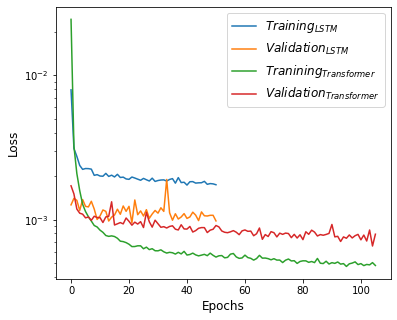

In [53]:
# Plot loss
plt.figure(figsize=(6,5))
plt.semilogy(result_lstm.history['loss'],label='$Training_{LSTM}$')
plt.semilogy(result_lstm.history['val_loss'],label='$Validation_{LSTM}$')
plt.semilogy(result_trans.history['loss'],label='$Tranining_{Transformer}$')
plt.semilogy(result_trans.history['val_loss'],label='$Validation_{Transformer}$')
plt.legend(loc=1, fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=12)

plt.savefig(path + 'Loss_surrogate_MIMO_TCLab_multistep.eps', format='eps')

## 5. Using measured values to predict next step

### LSTM

In [54]:
# # Load NN Models
model_lstm = load_model('MPC_MIMO_TCLab_multistep_LSTM_110000.h5')
model_trans = load_model('MPC_MIMO_TCLab_multistep_Trans_110000.h5')

In [55]:
# Verify the fit of the model
Yp_train_lstm = model_lstm.predict(X_train)
Yp_val_lstm = model_lstm.predict(X_val)

# un-scale outputs
# Yu_train_lstm = s2.inverse_transform(Yp_train_lstm) # model prediction
# Ym_train = s2.inverse_transform(Y_train) # measured value

# Yu_val_lstm = s2.inverse_transform(Yp_val_lstm) # model prediction
# Ym_val = s2.inverse_transform(Y_val) # measured value


# Verify the fit of the model
Yp_train_trans = model_trans.predict(X_train)
Yp_val_trans = model_trans.predict(X_val)

# un-scale outputs
# Yu_train_trans = s2.inverse_transform(Yp_train_trans) # model prediction
# Ym_train = s2.inverse_transform(Y_train) # measured value

# Yu_val_trans = s2.inverse_transform(Yp_val_trans) # model prediction
# Ym_val = s2.inverse_transform(Y_val) # measured value




# plt.figure(0, figsize=(30,4))
# plt.subplot(1,2,1)
# plt.plot(data.index[window:cut_index-P],Ym_train[:,0],'b-',label='Measured')
# plt.plot(data.index[window:cut_index-P],Yu_train_lstm[:,0],'r-',label='LSTM')
# plt.plot(data.index[window:cut_index-P],Yu_train_trans[:,0],'g--',label='Transformer')

# plt.title('Training')
# plt.legend()
# plt.subplot(1,2,2)
# plt.plot(data.index[cut_index+window:-P],Ym_val[:,0],'b-',label='Measured')
# plt.plot(data.index[cut_index+window:-P],Yu_val_lstm[:,0],'r-',label='LSTM')
# plt.plot(data.index[cut_index+window:-P],Yu_val_trans[:,0],'g--',label='Transformer')
# plt.title('Validation')
# plt.legend()

# plt.figure(1, figsize=(30,4))
# plt.subplot(1,2,1)
# plt.plot(data.index[window:cut_index-P],Ym_train[:,4],'b-',label='Measured')
# plt.plot(data.index[window:cut_index-P],Yu_train_lstm[:,4],'r-',label='LSTM')
# plt.plot(data.index[window:cut_index-P],Yu_train_trans[:,4],'g--',label='Transformer')
# plt.title('Training')
# plt.legend()

# plt.subplot(1,2,2)
# plt.plot(data.index[cut_index+window:-P],Ym_val[:,4],'b-',label='Measured')
# plt.plot(data.index[cut_index+window:-P],Yu_val_lstm[:,4],'r-',label='LSTM')
# plt.plot(data.index[cut_index+window:-P],Yu_val_trans[:,4],'g--',label='Transformer')
# plt.title('Validation')
# plt.legend()



ValueError: in user code:

    File "C:\Users\HAN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\HAN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\HAN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\HAN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\HAN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\HAN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 15, 4), found shape=(None, 10, 4)


In [ ]:
Y_train.shape

In [ ]:
plt.plot(Yp_val_trans[:,5,0])
plt.plot(Y_val[:,5,0],"--")

In [ ]:
a = Yp_val_trans.reshape(Yp_val_trans.shape[0], Yp_val_trans.shape[2], Yp_val_trans.shape[1])
b = Y_val.reshape(Y_val.shape[0], Y_val.shape[2], Y_val.shape[1])

In [ ]:
plt.plot(a[:220, 0, 9])
plt.plot(b[:220, 0, 9], '-.')

# Model Validation Results for paper

In [126]:
# Load NN model parameters and MinMaxScaler
model_params = load(open(path + 'model_param_MIMO.pkl', 'rb'))
s1 = model_params['Xscale']
s2 = model_params['yscale']
window = model_params['window']

# Load validation data
tcLab = pd.read_pickle('TCLab_MIMO_Data_027_15000_0_100.pkl')

# Downsample
interval = 30

downsampled_interval = interval # New interval (sec)
tcLab_resample = tcLab.iloc[::downsampled_interval, :]

# Select a Data Range to show
tcLab_resample = tcLab_resample[100:200]


# Scale
Xs = s1.transform(tcLab_resample[['H1', 'H2', 'T1', 'T2']])
Ys = s2.transform(tcLab_resample[['T1', 'T2']])

In [127]:
# Make snapshots
X_val = []
Y_val = []
for i in range(window,len(Xs)-P):
    X_val.append(Xs[i-window:i+P,:])
    Y_val.append(Ys[i:i+P])

In [128]:
# Reshape data to format accepted by LSTM
X_val, Y_val = np.array(X_val), np.array(Y_val)

In [129]:
for i in range(0, len(X_val)):
  X_val[i][window:,2] = X_val[i][window-1,2]
  X_val[i][window:,3] = X_val[i][window-1,3]

In [130]:
#Load NN Models
model_lstm = load_model('MPC_MIMO_TCLab_multistep_LSTM_125000_P5.h5')
model_trans = load_model('MPC_MIMO_TCLab_multistep_Trans_125000_P5.h5')

### LSTM-Multistep model evaluation

In [131]:
# Model prediction LSTM
Ytu_val_lstm = model_lstm.predict(X_val)    

# scale back to original range (LSTM Model value)
Yp_val_lstm = np.zeros_like(Ytu_val_lstm)
for i in range(len(Yp_val_lstm)):
    Yp_val_lstm[i] = s2.inverse_transform(Ytu_val_lstm[i])

# scale back to original range (Measered value)
Ym_val = np.zeros_like(Y_val)
for i in range(len(Y_val)):
    Ym_val[i] = s2.inverse_transform(Y_val[i])

2022-05-21 09:00:20.720206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-21 09:00:20.811605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-21 09:00:20.857408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-21 09:00:20.904795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Transformer-Multistep model evaluation

In [132]:
# Model prediction Transformer
Ytu_val_trans = model_trans.predict(X_val)    

# scale back to original range (Transformer Model value)
Yp_val_trans = np.zeros_like(Ytu_val_trans)
for i in range(len(Yp_val_trans)):
    Yp_val_trans[i] = s2.inverse_transform(Ytu_val_trans[i])

2022-05-21 09:00:21.090457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Plotting

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


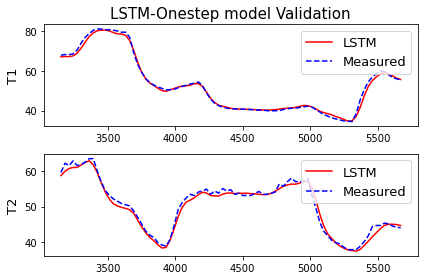

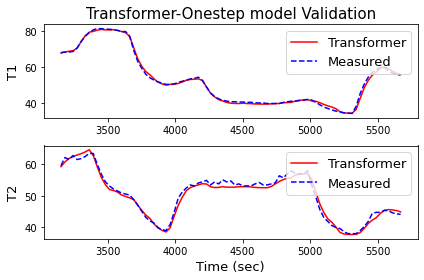

In [133]:
plt.figure(0, figsize=(6,4))
plt.subplot(2,1,1)
plt.plot(tcLab_resample.index[window:-P],Yp_val_lstm[:,5,0],'r-',label='LSTM')
plt.plot(tcLab_resample.index[window:-P],Ym_val[:,5,0],'b--',label='Measured')
plt.title('LSTM-Onestep model Validation',fontsize=15)
plt.ylabel("T1", fontsize=13)
plt.legend(loc=1,fontsize=13)
plt.subplot(2,1,2)
plt.plot(tcLab_resample.index[window:-P],Yp_val_lstm[:,5,1],'r-',label='LSTM')
plt.plot(tcLab_resample.index[window:-P],Ym_val[:,5,1],'b--',label='Measured')
# plt.title('Validation')
plt.ylabel("T2",fontsize=13)
plt.legend(loc=1,fontsize=13)
plt.tight_layout()


plt.savefig('TCLab_validation_LSTM_Multistep_data1.eps', format='eps')
plt.savefig('TCLab_validation_LSTM_Multistep_data1.png')

plt.figure(1, figsize=(6,4))
plt.subplot(2,1,1)
plt.plot(tcLab_resample.index[window:-P],Yp_val_trans[:,5,0],'r-',label='Transformer')
plt.plot(tcLab_resample.index[window:-P],Ym_val[:,5,0],'b--',label='Measured')
plt.title('Transformer-Onestep model Validation',fontsize=15)
plt.ylabel("T1",fontsize=13)
plt.legend(loc=1,fontsize=13)
plt.subplot(2,1,2)
plt.plot(tcLab_resample.index[window:-P],Yp_val_trans[:,5,1],'r-',label='Transformer')
plt.plot(tcLab_resample.index[window:-P],Ym_val[:,5,1],'b--',label='Measured')
# plt.title('Validation')
plt.ylabel("T2",fontsize=13)
plt.xlabel("Time (sec)",fontsize=13)
plt.legend(loc=1,fontsize=13)
plt.tight_layout()


plt.savefig('TCLab_validation_Transformer_Multistep_data1.eps', format='eps')
plt.savefig('TCLab_validation_Transformer_Multistep_data1.png')

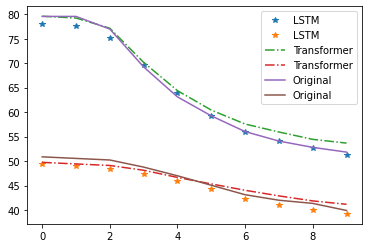

In [138]:
plt.plot(Yp_val_lstm[20], '*', label='LSTM')
plt.plot(Yp_val_trans[20], '-.', label='Transformer')

plt.plot(Ym_val[20], label='Original')
plt.legend()

In [141]:
Yp_val_trans[0]

array([[68.88472 , 55.56024 ],
       [68.2947  , 55.323486],
       [67.88686 , 54.761253],
       [67.884155, 55.557198],
       [67.648834, 57.354046],
       [67.73984 , 59.243843],
       [68.06431 , 60.539375],
       [68.30074 , 61.450207],
       [68.51828 , 61.786118],
       [69.62863 , 62.29061 ]], dtype=float32)

In [143]:
Yp_val_trans[9]

array([[70.936775, 63.19478 ],
       [74.110405, 63.595184],
       [77.21671 , 63.95112 ],
       [79.19483 , 64.603676],
       [79.61337 , 63.068157],
       [80.33806 , 59.164993],
       [80.46851 , 55.203903],
       [80.23825 , 52.655483],
       [79.85463 , 50.844105],
       [79.60394 , 49.69193 ]], dtype=float32)

In [144]:
t=np.linspace(0,19,20)

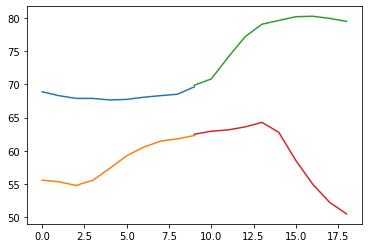

In [152]:
plt.plot(t[0:10], Yp_val_trans[0])
plt.plot(t[9:19], Yp_val_trans[8])

In [156]:
a = Yp_val_trans[0::10]
b = a.reshape(-1, 2)

In [161]:
a.shape

(9, 10, 2)

In [180]:
tcLab_meas = tcLab_resample.reset_index(drop=True)
tclab_meas = tcLab_meas.to_numpy()

In [185]:
tclab_meas[:,2][10:]

array([67.949, 68.271, 68.271, 68.594, 70.527, 74.072, 76.973, 78.906,
       80.518, 81.162, 81.162, 80.84 , 80.84 , 80.518, 80.195, 79.551,
       79.551, 76.973, 69.238, 63.115, 59.248, 56.025, 54.092, 52.803,
       51.836, 51.191, 50.386, 50.547, 50.708, 51.514, 52.158, 52.803,
       53.447, 53.77 , 54.414, 52.642, 48.936, 45.713, 43.779, 42.49 ,
       41.685, 41.201, 40.879, 40.879, 40.718, 40.718, 40.557, 40.557,
       40.234, 40.234, 40.234, 39.912, 39.912, 39.912, 39.912, 40.557,
       40.879, 41.201, 41.201, 41.523, 41.846, 42.168, 41.846, 40.557,
       39.268, 37.979, 37.173, 36.367, 35.723, 35.239, 34.756, 34.595,
       34.434, 38.301, 45.391, 50.547, 54.414, 56.992, 58.604, 59.893,
       59.731, 58.12 , 56.67 , 56.025, 55.542, 54.736, 54.736, 54.897,
       56.025, 56.348])

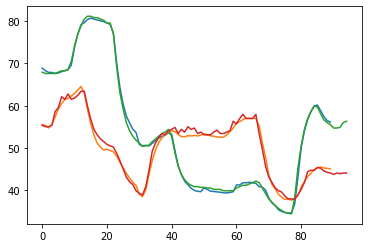

In [189]:
plt.plot(b)
plt.plot(tclab_meas[:,2:][5:])